In [19]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    AddChanneld,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
    Resized,
    ToTensord,
)
# from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import SimpleITK as sitk
import numpy as np


In [20]:
root_dir =  'E:/Tanvir Mehedi/Monai_Data/Saved_Models/Lung_Seg_3d/Full_Run/'


In [23]:
data_dir = 'E:/Tanvir Mehedi/Lung_segmentation/Data/'

train_images = sorted(
    glob.glob(os.path.join(data_dir, "CT_scan_nii", "*.nii")))

train_labels = sorted(
    glob.glob(os.path.join(data_dir, "Lung_mask_nii", "*.nii")))

data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]

train_files, val_files, test_files = data_dicts[0:20], data_dicts[20:25], data_dicts[25:]
print('Train files :', len(train_files),'\nValidation files :', len(val_files),'\nTest files :', len(test_files))


Train files : 20 
Validation files : 5 
Test files : 5


In [24]:
set_determinism(seed=0)

In [25]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"], a_min=-1200, a_max=600,
            b_min=0.0, b_max=1.0, clip=True),
        Orientationd(keys=["image", "label"], axcodes= 'SPL'),
        Spacingd(keys=["image", "label"], pixdim=(
            1., 1., 1.), mode=("bilinear", "nearest")),
        Resized(keys=["image"], spatial_size=[256,256,256], mode="trilinear", align_corners = True),
        Resized(keys=["label"], spatial_size=[256,256,256], mode="nearest"),
        ToTensord(keys=["image", "label"]),
    ]
)

val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"], a_min=-1200, a_max=600,
            b_min=0.0, b_max=1.0, clip=True),
        Orientationd(keys=["image", "label"], axcodes="SPL"),
        Spacingd(keys=["image", "label"], pixdim=(
            1., 1., 1.), mode=("bilinear", "nearest")),
        Resized(keys=["image"], spatial_size=[256,256,256], mode="trilinear", align_corners = True),
        Resized(keys=["label"], spatial_size=[256,256,256], mode="nearest"),
        ToTensord(keys=["image", "label"]),
    ]
)

test_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"], a_min=-1200, a_max=600,
            b_min=0.0, b_max=1.0, clip=True),
        Orientationd(keys=["image", "label"], axcodes="SPL"),
        Spacingd(keys=["image", "label"], pixdim=(
            1., 1., 1.), mode=("bilinear", "nearest")),
        Resized(keys=["image"], spatial_size=[256,256,256], mode="trilinear", align_corners = True),
        Resized(keys=["label"], spatial_size=[256,256,256], mode="nearest"),
        ToTensord(keys=["image", "label"]),
    ]
)


In [26]:
# check_ds = Dataset(data=train_files, transform=train_transforms)
# #check_ds = Dataset(data=train_files)
# check_loader = DataLoader(check_ds, batch_size=1)
# check_data = first(check_loader)
# image, label = (check_data["image"][0][0], check_data["label"][0][0])
# print(f"image shape: {image.shape}, label shape: {label.shape}")
# # plot the slice [:, :, 80]
# plt.figure("check", (12, 6))
# for i in range(200):
#     plt.subplot(1, 2, 1)
#     plt.title("image")
#     plt.imshow(image[i, :, :], cmap="gray")
#     plt.subplot(1, 2, 2)
#     plt.title("label")
#     plt.imshow(label[i, :, :],  cmap="gray")
#     plt.show()


# plt.subplot(1, 2, 1)
# plt.title("image")
# plt.imshow(image[:, :, 150], cmap="gray")
# plt.subplot(1, 2, 2)
# plt.title("label")
# plt.imshow(label[:, :, 150],  cmap="gray")
# plt.show()

In [27]:
# Model Parameters
batch_size = 1
num_workers = 0
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


# Dataloader

In [28]:
# Train
train_ds = Dataset(data = train_files, transform = train_transforms)
train_loader = DataLoader(train_ds, batch_size = batch_size, shuffle = True, num_workers = num_workers)

# Validation
val_ds = Dataset(data = val_files, transform = val_transforms)
val_loader = DataLoader(val_ds, batch_size = batch_size, num_workers = num_workers)

# Test
test_ds = Dataset(data = test_files, transform = test_transforms)
test_loader = DataLoader(test_ds, batch_size = batch_size, num_workers = num_workers)


# Set Model 

In [29]:
model = UNet(
    spatial_dims = 3,
    in_channels = 1,
    out_channels = 1,
    channels = (32, 64, 128, 256, 512),
    strides = (2, 2, 2, 2),
    num_res_units = 2,
    norm = Norm.BATCH,
).to(device)


In [30]:
loss_function = DiceLoss(to_onehot_y = False, sigmoid = True)

optimizer = torch.optim.Adam(model.parameters(), 1e-4)

dice_metric = DiceMetric(include_background = False, reduction = "mean")


# Train Model

In [31]:
def save_checkpoint(state, filename = 'lung_seg_3d_full_run_monai.pt.tar'):
    
    print('=> Saving Checkpoint')
    torch.save(state, filename)
    

In [32]:
max_epochs = 30
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []


In [ ]:
for epoch in range(max_epochs):
    
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    
    model.train()
    epoch_loss = 0
    step = 0
    
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = 2. , norm_type=2.0)
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        
        model.eval()
        
        with torch.no_grad():
            
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )

                # compute metric for current iteration
                val_outputs = model(val_inputs)
                val_outputs = torch.sigmoid(val_outputs)>0.5
                dice_metric(y_pred = val_outputs, y = val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                
                checkpoint = {'model_state' : model.state_dict(), 'optimizer_state' : optimizer.state_dict(), 
                              'Dice_Score' : metric } 
                save_checkpoint(checkpoint)
                
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )


----------
epoch 1/30
1/650, train_loss: 0.6820
2/650, train_loss: 0.8436
3/650, train_loss: 0.7482
4/650, train_loss: 0.7536
5/650, train_loss: 0.6737
6/650, train_loss: 0.8704
7/650, train_loss: 0.7264
8/650, train_loss: 0.7531
9/650, train_loss: 0.7578
10/650, train_loss: 0.7134
11/650, train_loss: 0.6673
12/650, train_loss: 0.6711
13/650, train_loss: 0.7682
14/650, train_loss: 0.7824
15/650, train_loss: 0.7439
16/650, train_loss: 0.7290
17/650, train_loss: 0.6890
18/650, train_loss: 0.8351
19/650, train_loss: 0.6999
20/650, train_loss: 0.6211
21/650, train_loss: 0.6388
22/650, train_loss: 0.6164
23/650, train_loss: 0.6897
24/650, train_loss: 0.7065
25/650, train_loss: 0.6996
26/650, train_loss: 0.7804
27/650, train_loss: 0.7073
28/650, train_loss: 0.6341
29/650, train_loss: 0.7001
30/650, train_loss: 0.6190
31/650, train_loss: 0.7158
32/650, train_loss: 0.6964
33/650, train_loss: 0.6866
34/650, train_loss: 0.6694
35/650, train_loss: 0.6980
36/650, train_loss: 0.7172
37/650, train_l

297/650, train_loss: 0.6923
298/650, train_loss: 0.6408
299/650, train_loss: 0.7900
300/650, train_loss: 0.5626
301/650, train_loss: 0.7481
302/650, train_loss: 0.6627
303/650, train_loss: 0.6432
304/650, train_loss: 0.6852
305/650, train_loss: 0.5227
306/650, train_loss: 0.5174
307/650, train_loss: 0.6091
308/650, train_loss: 0.5520
309/650, train_loss: 0.6372
310/650, train_loss: 0.6901
311/650, train_loss: 0.5483
312/650, train_loss: 0.5986
313/650, train_loss: 0.5218
314/650, train_loss: 0.6874
315/650, train_loss: 0.6760
316/650, train_loss: 0.7125
317/650, train_loss: 0.6099
318/650, train_loss: 0.5947
319/650, train_loss: 0.5139
320/650, train_loss: 0.5337
321/650, train_loss: 0.5163
322/650, train_loss: 0.6057
323/650, train_loss: 0.6153
324/650, train_loss: 0.6405
325/650, train_loss: 0.6806
326/650, train_loss: 0.6622
327/650, train_loss: 0.6947
328/650, train_loss: 0.6406
329/650, train_loss: 0.4838
330/650, train_loss: 0.5318
331/650, train_loss: 0.6520
332/650, train_loss:

590/650, train_loss: 0.6233
591/650, train_loss: 0.6878
592/650, train_loss: 0.4942
593/650, train_loss: 0.5119
594/650, train_loss: 0.5954
595/650, train_loss: 0.4836
596/650, train_loss: 0.5880
597/650, train_loss: 0.4372
598/650, train_loss: 0.5720
599/650, train_loss: 0.5408
600/650, train_loss: 0.5451
601/650, train_loss: 0.6058
602/650, train_loss: 0.4517
603/650, train_loss: 0.7295
604/650, train_loss: 0.7620
605/650, train_loss: 0.5869
606/650, train_loss: 0.5544
607/650, train_loss: 0.5096
608/650, train_loss: 0.5433
609/650, train_loss: 0.6439
610/650, train_loss: 0.5001
611/650, train_loss: 0.5979
612/650, train_loss: 0.6228
613/650, train_loss: 0.7137
614/650, train_loss: 0.8416
615/650, train_loss: 0.6174
616/650, train_loss: 0.7545
617/650, train_loss: 0.5150
618/650, train_loss: 0.6307
619/650, train_loss: 0.7873
620/650, train_loss: 0.6902
621/650, train_loss: 0.5406
622/650, train_loss: 0.6105
623/650, train_loss: 0.4926
624/650, train_loss: 0.5819
625/650, train_loss:

235/650, train_loss: 0.6156
236/650, train_loss: 0.6010
237/650, train_loss: 0.7445
238/650, train_loss: 0.6802
239/650, train_loss: 0.5264
240/650, train_loss: 0.4703
241/650, train_loss: 0.4966
242/650, train_loss: 0.6817
243/650, train_loss: 0.5254
244/650, train_loss: 0.7131
245/650, train_loss: 0.5163
246/650, train_loss: 0.6455
247/650, train_loss: 0.5283
248/650, train_loss: 0.5841
249/650, train_loss: 0.6368
250/650, train_loss: 0.4918
251/650, train_loss: 0.6061
252/650, train_loss: 0.5577
253/650, train_loss: 0.4511
254/650, train_loss: 0.5859
255/650, train_loss: 0.4756
256/650, train_loss: 0.4801
257/650, train_loss: 0.5451
258/650, train_loss: 0.5801
259/650, train_loss: 0.4897
260/650, train_loss: 0.4558
261/650, train_loss: 0.6481
262/650, train_loss: 0.5864
263/650, train_loss: 0.5432
264/650, train_loss: 0.6631
265/650, train_loss: 0.7561
266/650, train_loss: 0.4566
267/650, train_loss: 0.4851
268/650, train_loss: 0.6651
269/650, train_loss: 0.4308
270/650, train_loss:

528/650, train_loss: 0.4164
529/650, train_loss: 0.5608
530/650, train_loss: 0.6113
531/650, train_loss: 0.4754
532/650, train_loss: 0.4478
533/650, train_loss: 0.5291
534/650, train_loss: 0.4562
535/650, train_loss: 0.4772
536/650, train_loss: 0.5469
537/650, train_loss: 0.3964
538/650, train_loss: 0.4993
539/650, train_loss: 0.4445
540/650, train_loss: 0.4693
541/650, train_loss: 0.6084
542/650, train_loss: 0.4784
543/650, train_loss: 0.5925
544/650, train_loss: 0.5270
545/650, train_loss: 0.5596
546/650, train_loss: 0.4111
547/650, train_loss: 0.4867
548/650, train_loss: 0.4798
549/650, train_loss: 0.5785
550/650, train_loss: 0.3924
551/650, train_loss: 0.6045
552/650, train_loss: 0.5614
553/650, train_loss: 0.5026
554/650, train_loss: 0.4459
555/650, train_loss: 0.4246
556/650, train_loss: 0.4291
557/650, train_loss: 0.4948
558/650, train_loss: 0.4454
559/650, train_loss: 0.5090
560/650, train_loss: 0.4156
561/650, train_loss: 0.5399
562/650, train_loss: 0.7190
563/650, train_loss:

169/650, train_loss: 0.3536
170/650, train_loss: 0.4163
171/650, train_loss: 0.4533
172/650, train_loss: 0.4298
173/650, train_loss: 0.3836
174/650, train_loss: 0.3884
175/650, train_loss: 0.5640
176/650, train_loss: 0.4707
177/650, train_loss: 0.3977
178/650, train_loss: 0.3601
179/650, train_loss: 0.3680
180/650, train_loss: 0.2590
181/650, train_loss: 0.5326
182/650, train_loss: 0.4436
183/650, train_loss: 0.2615
184/650, train_loss: 0.4221
185/650, train_loss: 0.3563
186/650, train_loss: 0.4768
187/650, train_loss: 0.3519
188/650, train_loss: 0.6610
189/650, train_loss: 0.3838
190/650, train_loss: 0.4708
191/650, train_loss: 0.3375
192/650, train_loss: 0.6048
193/650, train_loss: 0.6590
194/650, train_loss: 0.4804
195/650, train_loss: 0.5071
196/650, train_loss: 0.4993
197/650, train_loss: 0.6820
198/650, train_loss: 0.4388
199/650, train_loss: 0.3423
200/650, train_loss: 0.3151
201/650, train_loss: 0.6030
202/650, train_loss: 0.4614
203/650, train_loss: 0.5406
204/650, train_loss:

462/650, train_loss: 0.3592
463/650, train_loss: 0.2948
464/650, train_loss: 0.1997
465/650, train_loss: 0.6020
466/650, train_loss: 0.3051
467/650, train_loss: 0.3065
468/650, train_loss: 0.2011
469/650, train_loss: 0.3730
470/650, train_loss: 0.2284
471/650, train_loss: 0.2381
472/650, train_loss: 0.3383
473/650, train_loss: 0.3788
474/650, train_loss: 0.1929
475/650, train_loss: 0.3054
476/650, train_loss: 0.2955
477/650, train_loss: 0.1557
478/650, train_loss: 0.4995
479/650, train_loss: 0.2508
480/650, train_loss: 0.2221
481/650, train_loss: 0.1860
482/650, train_loss: 0.1137
483/650, train_loss: 0.2338
484/650, train_loss: 0.1642
485/650, train_loss: 0.4583
486/650, train_loss: 0.3931
487/650, train_loss: 0.2346
488/650, train_loss: 0.3302
489/650, train_loss: 0.3423
490/650, train_loss: 0.2693
491/650, train_loss: 0.3794
492/650, train_loss: 0.5584
493/650, train_loss: 0.3356
494/650, train_loss: 0.1602
495/650, train_loss: 0.1918
496/650, train_loss: 0.3186
497/650, train_loss:

107/650, train_loss: 0.1636
108/650, train_loss: 0.1927
109/650, train_loss: 0.2350
110/650, train_loss: 0.2226
111/650, train_loss: 0.2195
112/650, train_loss: 0.3269
113/650, train_loss: 0.2362
114/650, train_loss: 0.3085
115/650, train_loss: 0.0866
116/650, train_loss: 0.1366
117/650, train_loss: 0.3486
118/650, train_loss: 0.1036
119/650, train_loss: 0.2010
120/650, train_loss: 0.1369
121/650, train_loss: 0.1452
122/650, train_loss: 0.0877
123/650, train_loss: 0.2325
124/650, train_loss: 0.4135
125/650, train_loss: 0.1604
126/650, train_loss: 0.1518
127/650, train_loss: 0.1117
128/650, train_loss: 0.0941
129/650, train_loss: 0.5239
130/650, train_loss: 0.2441
131/650, train_loss: 0.1938
132/650, train_loss: 0.2203
133/650, train_loss: 0.1911
134/650, train_loss: 0.1059
135/650, train_loss: 0.1018
136/650, train_loss: 0.2911
137/650, train_loss: 0.1447
138/650, train_loss: 0.0877
139/650, train_loss: 0.0870
140/650, train_loss: 0.1167
141/650, train_loss: 0.1678
142/650, train_loss:

400/650, train_loss: 0.0648
401/650, train_loss: 0.0930
402/650, train_loss: 0.1645
403/650, train_loss: 0.0599
404/650, train_loss: 0.1486
405/650, train_loss: 0.1537
406/650, train_loss: 0.1375
407/650, train_loss: 0.1403
408/650, train_loss: 0.1383
409/650, train_loss: 0.0494
410/650, train_loss: 0.1556
411/650, train_loss: 0.0832
412/650, train_loss: 0.1180
413/650, train_loss: 0.1891
414/650, train_loss: 0.1399
415/650, train_loss: 0.1576
416/650, train_loss: 0.0775
417/650, train_loss: 0.1119
418/650, train_loss: 0.3815
419/650, train_loss: 0.2570
420/650, train_loss: 0.1987
421/650, train_loss: 0.1064
422/650, train_loss: 0.1462
423/650, train_loss: 0.0987
424/650, train_loss: 0.2456
425/650, train_loss: 0.0741
426/650, train_loss: 0.1166
427/650, train_loss: 0.0902
428/650, train_loss: 0.1055
429/650, train_loss: 0.2224
430/650, train_loss: 0.1322
431/650, train_loss: 0.3822
432/650, train_loss: 0.3053
433/650, train_loss: 0.1076
434/650, train_loss: 0.0529
435/650, train_loss:

38/650, train_loss: 0.0608
39/650, train_loss: 0.1139
40/650, train_loss: 0.0621
41/650, train_loss: 0.0446
42/650, train_loss: 0.0842
43/650, train_loss: 0.0600
44/650, train_loss: 0.0547
45/650, train_loss: 0.0459
46/650, train_loss: 0.1007
47/650, train_loss: 0.0982
48/650, train_loss: 0.1230
49/650, train_loss: 0.0713
50/650, train_loss: 0.1185
51/650, train_loss: 0.0736
52/650, train_loss: 0.1414
53/650, train_loss: 0.0597
54/650, train_loss: 0.1336
55/650, train_loss: 0.0567
56/650, train_loss: 0.0244
57/650, train_loss: 0.0282
58/650, train_loss: 0.0473
59/650, train_loss: 0.1330
60/650, train_loss: 0.0917
61/650, train_loss: 0.0781
62/650, train_loss: 0.0468
63/650, train_loss: 0.1555
64/650, train_loss: 0.1368
65/650, train_loss: 0.1015
66/650, train_loss: 0.0550
67/650, train_loss: 0.1137
68/650, train_loss: 0.0578
69/650, train_loss: 0.1971
70/650, train_loss: 0.2705
71/650, train_loss: 0.0524
72/650, train_loss: 0.0554
73/650, train_loss: 0.1370
74/650, train_loss: 0.0343
7

333/650, train_loss: 0.0464
334/650, train_loss: 0.1687
335/650, train_loss: 0.0401
336/650, train_loss: 0.0634
337/650, train_loss: 0.0871
338/650, train_loss: 0.0346
339/650, train_loss: 0.1074
340/650, train_loss: 0.0316
341/650, train_loss: 0.0610
342/650, train_loss: 0.0624
343/650, train_loss: 0.0871
344/650, train_loss: 0.1086
345/650, train_loss: 0.0605
346/650, train_loss: 0.0536
347/650, train_loss: 0.0526
348/650, train_loss: 0.0380
349/650, train_loss: 0.3053
350/650, train_loss: 0.0561
351/650, train_loss: 0.0349
352/650, train_loss: 0.0381
353/650, train_loss: 0.1481
354/650, train_loss: 0.0300
355/650, train_loss: 0.1171
356/650, train_loss: 0.0907
357/650, train_loss: 0.0479
358/650, train_loss: 0.1222
359/650, train_loss: 0.0297
360/650, train_loss: 0.0643
361/650, train_loss: 0.0289
362/650, train_loss: 0.0907
363/650, train_loss: 0.0287
364/650, train_loss: 0.0649
365/650, train_loss: 0.0245
366/650, train_loss: 0.0881
367/650, train_loss: 0.0538
368/650, train_loss:

626/650, train_loss: 0.0222
627/650, train_loss: 0.0413
628/650, train_loss: 0.1071
629/650, train_loss: 0.0271
630/650, train_loss: 0.0240
631/650, train_loss: 0.0323
632/650, train_loss: 0.0279
633/650, train_loss: 0.0357
634/650, train_loss: 0.0613
635/650, train_loss: 0.0178
636/650, train_loss: 0.0411
637/650, train_loss: 0.0543
638/650, train_loss: 0.0796
639/650, train_loss: 0.1439
640/650, train_loss: 0.0618
641/650, train_loss: 0.0370
642/650, train_loss: 0.0219
643/650, train_loss: 0.0406
644/650, train_loss: 0.0285
645/650, train_loss: 0.0676
646/650, train_loss: 0.0249
647/650, train_loss: 0.0404
648/650, train_loss: 0.0294
649/650, train_loss: 0.0496
650/650, train_loss: 0.0993
epoch 5 average loss: 0.0740
----------
epoch 6/30
1/650, train_loss: 0.0526
2/650, train_loss: 0.0499
3/650, train_loss: 0.0706
4/650, train_loss: 0.0697
5/650, train_loss: 0.0351
6/650, train_loss: 0.0301
7/650, train_loss: 0.0608
8/650, train_loss: 0.0317
9/650, train_loss: 0.0335
10/650, train_l

271/650, train_loss: 0.0256
272/650, train_loss: 0.0166
273/650, train_loss: 0.0196
274/650, train_loss: 0.0710
275/650, train_loss: 0.0532
276/650, train_loss: 0.0284
277/650, train_loss: 0.0239
278/650, train_loss: 0.0685
279/650, train_loss: 0.0358
280/650, train_loss: 0.0232
281/650, train_loss: 0.0225
282/650, train_loss: 0.0207
283/650, train_loss: 0.0421
284/650, train_loss: 0.1316
285/650, train_loss: 0.0195
286/650, train_loss: 0.0200
287/650, train_loss: 0.0318
288/650, train_loss: 0.0202
289/650, train_loss: 0.0219
290/650, train_loss: 0.0222
291/650, train_loss: 0.0350
292/650, train_loss: 0.0401
293/650, train_loss: 0.0366
294/650, train_loss: 0.0461
295/650, train_loss: 0.0355
296/650, train_loss: 0.0210
297/650, train_loss: 0.0291
298/650, train_loss: 0.0224
299/650, train_loss: 0.0287
300/650, train_loss: 0.0224
301/650, train_loss: 0.0300
302/650, train_loss: 0.0343
303/650, train_loss: 0.0219
304/650, train_loss: 0.0216
305/650, train_loss: 0.0293
306/650, train_loss:

564/650, train_loss: 0.0190
565/650, train_loss: 0.6438
566/650, train_loss: 0.0154
567/650, train_loss: 0.0410
568/650, train_loss: 0.0245
569/650, train_loss: 0.0163
570/650, train_loss: 0.0282
571/650, train_loss: 0.0160
572/650, train_loss: 0.0168
573/650, train_loss: 0.0355
574/650, train_loss: 0.0373
575/650, train_loss: 0.0557
576/650, train_loss: 0.0176
577/650, train_loss: 0.0297
578/650, train_loss: 0.0294
579/650, train_loss: 0.0191
580/650, train_loss: 0.0218
581/650, train_loss: 0.0419
582/650, train_loss: 0.0224
583/650, train_loss: 0.0298
584/650, train_loss: 0.0247
585/650, train_loss: 0.0303
586/650, train_loss: 0.0500
587/650, train_loss: 0.0805
588/650, train_loss: 0.0160
589/650, train_loss: 0.0135
590/650, train_loss: 0.0174
591/650, train_loss: 0.0204
592/650, train_loss: 0.0274
593/650, train_loss: 0.0411
594/650, train_loss: 0.0207
595/650, train_loss: 0.0562
596/650, train_loss: 0.0478
597/650, train_loss: 0.0307
598/650, train_loss: 0.0186
599/650, train_loss:

205/650, train_loss: 0.0189
206/650, train_loss: 0.0611
207/650, train_loss: 0.2587
208/650, train_loss: 0.0221
209/650, train_loss: 0.0197
210/650, train_loss: 0.0198
211/650, train_loss: 0.0513
212/650, train_loss: 0.0532
213/650, train_loss: 0.0179
214/650, train_loss: 0.0143
215/650, train_loss: 0.0272
216/650, train_loss: 0.0431
217/650, train_loss: 0.0158
218/650, train_loss: 0.0223
219/650, train_loss: 0.0236
220/650, train_loss: 0.0330
221/650, train_loss: 0.0225
222/650, train_loss: 0.0159
223/650, train_loss: 0.0208
224/650, train_loss: 0.0233
225/650, train_loss: 0.0149
226/650, train_loss: 0.0477
227/650, train_loss: 0.0215
228/650, train_loss: 0.0361
229/650, train_loss: 0.0239
230/650, train_loss: 0.0177
231/650, train_loss: 0.0483
232/650, train_loss: 0.0367
233/650, train_loss: 0.0335
234/650, train_loss: 0.6646
235/650, train_loss: 0.0183
236/650, train_loss: 0.0173
237/650, train_loss: 0.0216
238/650, train_loss: 0.0194
239/650, train_loss: 0.0428
240/650, train_loss:

498/650, train_loss: 0.0332
499/650, train_loss: 0.0303
500/650, train_loss: 0.0211
501/650, train_loss: 0.0162
502/650, train_loss: 0.0334
503/650, train_loss: 0.0198
504/650, train_loss: 0.0204
505/650, train_loss: 0.0143
506/650, train_loss: 0.0166
507/650, train_loss: 0.0321
508/650, train_loss: 0.0259
509/650, train_loss: 0.0370
510/650, train_loss: 0.0153
511/650, train_loss: 0.0151
512/650, train_loss: 0.0253
513/650, train_loss: 0.0257
514/650, train_loss: 0.0148
515/650, train_loss: 0.0181
516/650, train_loss: 0.0170
517/650, train_loss: 0.0181
518/650, train_loss: 0.0200
519/650, train_loss: 0.0137
520/650, train_loss: 0.0213
521/650, train_loss: 0.0309
522/650, train_loss: 0.0152
523/650, train_loss: 0.0233
524/650, train_loss: 0.0149
525/650, train_loss: 0.0187
526/650, train_loss: 0.0197
527/650, train_loss: 0.0178
528/650, train_loss: 0.0149
529/650, train_loss: 0.0207
530/650, train_loss: 0.0437
531/650, train_loss: 0.0256
532/650, train_loss: 0.0265
533/650, train_loss:

143/650, train_loss: 0.0411
144/650, train_loss: 0.0168
145/650, train_loss: 0.0327
146/650, train_loss: 0.0271
147/650, train_loss: 0.0224
148/650, train_loss: 0.0269
149/650, train_loss: 0.0186
150/650, train_loss: 0.0169
151/650, train_loss: 0.0166
152/650, train_loss: 0.0244
153/650, train_loss: 0.0160
154/650, train_loss: 0.0211
155/650, train_loss: 0.0195
156/650, train_loss: 0.0207
157/650, train_loss: 0.0231
158/650, train_loss: 0.0159
159/650, train_loss: 0.0158
160/650, train_loss: 0.0188
161/650, train_loss: 0.0142
162/650, train_loss: 0.0134
163/650, train_loss: 0.0373
164/650, train_loss: 0.0221
165/650, train_loss: 0.0205
166/650, train_loss: 0.0262
167/650, train_loss: 0.0210
168/650, train_loss: 0.0286
169/650, train_loss: 0.0525
170/650, train_loss: 0.0152
171/650, train_loss: 0.0131
172/650, train_loss: 0.0201
173/650, train_loss: 0.0155
174/650, train_loss: 0.0642
175/650, train_loss: 0.0216
176/650, train_loss: 0.0244
177/650, train_loss: 0.0248
178/650, train_loss:

436/650, train_loss: 0.0189
437/650, train_loss: 0.0394
438/650, train_loss: 0.0180
439/650, train_loss: 0.0258
440/650, train_loss: 0.0271
441/650, train_loss: 0.0202
442/650, train_loss: 0.0239
443/650, train_loss: 0.0256
444/650, train_loss: 0.0232
445/650, train_loss: 0.0169
446/650, train_loss: 0.0158
447/650, train_loss: 0.0171
448/650, train_loss: 0.0146
449/650, train_loss: 0.0181
450/650, train_loss: 0.0178
451/650, train_loss: 0.0167
452/650, train_loss: 0.0217
453/650, train_loss: 0.0305
454/650, train_loss: 0.0145
455/650, train_loss: 0.0327
456/650, train_loss: 0.0177
457/650, train_loss: 0.0190
458/650, train_loss: 0.0303
459/650, train_loss: 0.0224
460/650, train_loss: 0.0189
461/650, train_loss: 0.0155
462/650, train_loss: 0.0319
463/650, train_loss: 0.0319
464/650, train_loss: 0.0106
465/650, train_loss: 0.0236
466/650, train_loss: 0.0146
467/650, train_loss: 0.0154
468/650, train_loss: 0.0143
469/650, train_loss: 0.0164
470/650, train_loss: 0.0323
471/650, train_loss:

76/650, train_loss: 0.0182
77/650, train_loss: 0.0188
78/650, train_loss: 0.0226
79/650, train_loss: 0.0293
80/650, train_loss: 0.0187
81/650, train_loss: 0.0120
82/650, train_loss: 0.0216
83/650, train_loss: 0.0213
84/650, train_loss: 0.0142
85/650, train_loss: 0.0178
86/650, train_loss: 0.0206
87/650, train_loss: 0.0238
88/650, train_loss: 0.0123
89/650, train_loss: 0.0141
90/650, train_loss: 0.0177
91/650, train_loss: 0.0163
92/650, train_loss: 0.0206
93/650, train_loss: 0.0158
94/650, train_loss: 0.0231
95/650, train_loss: 0.0152
96/650, train_loss: 0.0229
97/650, train_loss: 0.0122
98/650, train_loss: 0.0226
99/650, train_loss: 0.0186
100/650, train_loss: 0.0158
101/650, train_loss: 0.0260
102/650, train_loss: 0.0212
103/650, train_loss: 0.0149
104/650, train_loss: 0.0131
105/650, train_loss: 0.0184
106/650, train_loss: 0.0160
107/650, train_loss: 0.0214
108/650, train_loss: 0.0152
109/650, train_loss: 0.0210
110/650, train_loss: 0.0137
111/650, train_loss: 0.0158
112/650, train_l

370/650, train_loss: 0.0127
371/650, train_loss: 0.0229
372/650, train_loss: 0.0127
373/650, train_loss: 0.0258
374/650, train_loss: 0.0141
375/650, train_loss: 0.0121
376/650, train_loss: 0.0135
377/650, train_loss: 0.0171
378/650, train_loss: 0.0139
379/650, train_loss: 0.0226
380/650, train_loss: 0.0137
381/650, train_loss: 0.0199
382/650, train_loss: 0.0115
383/650, train_loss: 0.0319
384/650, train_loss: 0.0132
385/650, train_loss: 0.0180
386/650, train_loss: 0.0311
387/650, train_loss: 0.0184
388/650, train_loss: 0.0121
389/650, train_loss: 0.0177
390/650, train_loss: 0.0136
391/650, train_loss: 0.0249
392/650, train_loss: 0.0220
393/650, train_loss: 0.0112
394/650, train_loss: 0.0308
395/650, train_loss: 0.0107
396/650, train_loss: 0.0144
397/650, train_loss: 0.0111
398/650, train_loss: 0.0326
399/650, train_loss: 0.0172
400/650, train_loss: 0.0267
401/650, train_loss: 0.0122
402/650, train_loss: 0.0290
403/650, train_loss: 0.0177
404/650, train_loss: 0.0228
405/650, train_loss:

12/650, train_loss: 0.0449
13/650, train_loss: 0.0191
14/650, train_loss: 0.0137
15/650, train_loss: 0.0110
16/650, train_loss: 0.0125
17/650, train_loss: 0.0128
18/650, train_loss: 0.0133
19/650, train_loss: 0.0134
20/650, train_loss: 0.0187
21/650, train_loss: 0.0158
22/650, train_loss: 0.0165
23/650, train_loss: 0.0163
24/650, train_loss: 0.0425
25/650, train_loss: 0.0242
26/650, train_loss: 0.0190
27/650, train_loss: 0.0183
28/650, train_loss: 0.0137
29/650, train_loss: 0.0277
30/650, train_loss: 0.0230
31/650, train_loss: 0.0337
32/650, train_loss: 0.0128
33/650, train_loss: 0.0119
34/650, train_loss: 0.0135
35/650, train_loss: 0.0106
36/650, train_loss: 0.0142
37/650, train_loss: 0.0157
38/650, train_loss: 0.0154
39/650, train_loss: 0.0130
40/650, train_loss: 0.0115
41/650, train_loss: 0.0149
42/650, train_loss: 0.0113
43/650, train_loss: 0.0156
44/650, train_loss: 0.0232
45/650, train_loss: 0.0117
46/650, train_loss: 0.0183
47/650, train_loss: 0.0204
48/650, train_loss: 0.0162
4

308/650, train_loss: 0.0113
309/650, train_loss: 0.0182
310/650, train_loss: 0.0117
311/650, train_loss: 0.0159
312/650, train_loss: 0.0138
313/650, train_loss: 0.0154
314/650, train_loss: 0.0122
315/650, train_loss: 0.0518
316/650, train_loss: 0.0202
317/650, train_loss: 0.0116
318/650, train_loss: 0.0147
319/650, train_loss: 0.0175
320/650, train_loss: 0.0117
321/650, train_loss: 0.0145
322/650, train_loss: 0.0150
323/650, train_loss: 0.0194
324/650, train_loss: 0.0457
325/650, train_loss: 0.0365
326/650, train_loss: 0.0189
327/650, train_loss: 0.0142
328/650, train_loss: 0.0157
329/650, train_loss: 0.0101
330/650, train_loss: 0.0139
331/650, train_loss: 0.0155
332/650, train_loss: 0.0138
333/650, train_loss: 0.0179
334/650, train_loss: 0.0278
335/650, train_loss: 0.0274
336/650, train_loss: 0.0156
337/650, train_loss: 0.0152
338/650, train_loss: 0.0157
339/650, train_loss: 0.0191
340/650, train_loss: 0.0207
341/650, train_loss: 0.0125
342/650, train_loss: 0.0110
343/650, train_loss:

601/650, train_loss: 0.0126
602/650, train_loss: 0.0191
603/650, train_loss: 0.0219
604/650, train_loss: 0.0143
605/650, train_loss: 0.0158
606/650, train_loss: 0.4367
607/650, train_loss: 0.0201
608/650, train_loss: 0.0113
609/650, train_loss: 0.0123
610/650, train_loss: 0.0134
611/650, train_loss: 0.0131
612/650, train_loss: 0.0143
613/650, train_loss: 0.0221
614/650, train_loss: 0.0154
615/650, train_loss: 0.0181
616/650, train_loss: 0.0230
617/650, train_loss: 0.0388
618/650, train_loss: 0.0373
619/650, train_loss: 0.0270
620/650, train_loss: 0.0123
621/650, train_loss: 0.0163
622/650, train_loss: 0.0098
623/650, train_loss: 0.0151
624/650, train_loss: 0.0160
625/650, train_loss: 0.0149
626/650, train_loss: 0.0197
627/650, train_loss: 0.0167
628/650, train_loss: 0.0167
629/650, train_loss: 0.0104
630/650, train_loss: 0.0127
631/650, train_loss: 0.0132
632/650, train_loss: 0.0163
633/650, train_loss: 0.0230
634/650, train_loss: 0.0149
635/650, train_loss: 0.0107
636/650, train_loss:

243/650, train_loss: 0.0166
244/650, train_loss: 0.0132
245/650, train_loss: 0.0176
246/650, train_loss: 0.0106
247/650, train_loss: 0.0154
248/650, train_loss: 0.0208
249/650, train_loss: 0.0129
250/650, train_loss: 0.0176
251/650, train_loss: 0.0148
252/650, train_loss: 0.0143
253/650, train_loss: 0.0122
254/650, train_loss: 0.0183
255/650, train_loss: 0.0104
256/650, train_loss: 0.0149
257/650, train_loss: 0.0119
258/650, train_loss: 0.0179
259/650, train_loss: 0.0147
260/650, train_loss: 0.0376
261/650, train_loss: 0.0170
262/650, train_loss: 0.0121
263/650, train_loss: 0.4658
264/650, train_loss: 0.0134
265/650, train_loss: 0.0165
266/650, train_loss: 0.0230
267/650, train_loss: 0.0178
268/650, train_loss: 0.0266
269/650, train_loss: 0.0134
270/650, train_loss: 0.0133
271/650, train_loss: 0.0227
272/650, train_loss: 0.0126
273/650, train_loss: 0.0222
274/650, train_loss: 0.0127
275/650, train_loss: 0.0183
276/650, train_loss: 0.0112
277/650, train_loss: 0.0185
278/650, train_loss:

536/650, train_loss: 0.0110
537/650, train_loss: 0.0148
538/650, train_loss: 0.0181
539/650, train_loss: 0.0151
540/650, train_loss: 0.0112
541/650, train_loss: 0.0149
542/650, train_loss: 0.0125
543/650, train_loss: 0.0127
544/650, train_loss: 0.0153
545/650, train_loss: 0.0153
546/650, train_loss: 0.0134
547/650, train_loss: 0.0140
548/650, train_loss: 0.0131
549/650, train_loss: 0.0179
550/650, train_loss: 0.0227
551/650, train_loss: 0.0162
552/650, train_loss: 0.0128
553/650, train_loss: 0.0161
554/650, train_loss: 0.0096
555/650, train_loss: 0.0143
556/650, train_loss: 0.0162
557/650, train_loss: 0.0150
558/650, train_loss: 0.0159
559/650, train_loss: 0.0124
560/650, train_loss: 0.0185
561/650, train_loss: 0.0146
562/650, train_loss: 0.0123
563/650, train_loss: 0.0166
564/650, train_loss: 0.0146
565/650, train_loss: 0.0339
566/650, train_loss: 0.0127
567/650, train_loss: 0.0129
568/650, train_loss: 0.0093
569/650, train_loss: 0.0155
570/650, train_loss: 0.0135
571/650, train_loss:

181/650, train_loss: 0.0194
182/650, train_loss: 0.0175
183/650, train_loss: 0.0154
184/650, train_loss: 0.0196
185/650, train_loss: 0.0127
186/650, train_loss: 0.0119
187/650, train_loss: 0.0111
188/650, train_loss: 0.0161
189/650, train_loss: 0.0115
190/650, train_loss: 0.0141
191/650, train_loss: 0.0186
192/650, train_loss: 0.0126
193/650, train_loss: 0.0164
194/650, train_loss: 0.0103
195/650, train_loss: 0.0141
196/650, train_loss: 0.0135
197/650, train_loss: 0.0140
198/650, train_loss: 0.0127
199/650, train_loss: 0.0100
200/650, train_loss: 0.0118
201/650, train_loss: 0.0124
202/650, train_loss: 0.0129
203/650, train_loss: 0.0153
204/650, train_loss: 0.0120
205/650, train_loss: 0.0245
206/650, train_loss: 0.4359
207/650, train_loss: 0.0175
208/650, train_loss: 0.0211
209/650, train_loss: 0.0213
210/650, train_loss: 0.0148
211/650, train_loss: 0.0115
212/650, train_loss: 0.0125
213/650, train_loss: 0.0150
214/650, train_loss: 0.0123
215/650, train_loss: 0.0142
216/650, train_loss:

474/650, train_loss: 0.0340
475/650, train_loss: 0.0150
476/650, train_loss: 0.0210
477/650, train_loss: 0.0107
478/650, train_loss: 0.0206
479/650, train_loss: 0.0142
480/650, train_loss: 0.0174
481/650, train_loss: 0.0213
482/650, train_loss: 0.0108
483/650, train_loss: 0.0129
484/650, train_loss: 0.0108
485/650, train_loss: 0.0169
486/650, train_loss: 0.0163
487/650, train_loss: 0.0451
488/650, train_loss: 0.0201
489/650, train_loss: 0.0130
490/650, train_loss: 0.0184
491/650, train_loss: 0.0196
492/650, train_loss: 0.0235
493/650, train_loss: 0.0201
494/650, train_loss: 0.0128
495/650, train_loss: 0.0150
496/650, train_loss: 0.0153
497/650, train_loss: 0.0165
498/650, train_loss: 0.0121
499/650, train_loss: 0.0116
500/650, train_loss: 0.0178
501/650, train_loss: 0.0168
502/650, train_loss: 0.0191
503/650, train_loss: 0.0134
504/650, train_loss: 0.0271
505/650, train_loss: 0.0151
506/650, train_loss: 0.0191
507/650, train_loss: 0.0157
508/650, train_loss: 0.0177
509/650, train_loss:

116/650, train_loss: 0.2534
117/650, train_loss: 0.0112
118/650, train_loss: 0.0677
119/650, train_loss: 0.0196
120/650, train_loss: 0.0164
121/650, train_loss: 0.0285
122/650, train_loss: 0.0206
123/650, train_loss: 0.0161
124/650, train_loss: 0.0186
125/650, train_loss: 0.0139
126/650, train_loss: 0.0899
127/650, train_loss: 0.0138
128/650, train_loss: 0.0184
129/650, train_loss: 0.0125
130/650, train_loss: 0.0192
131/650, train_loss: 0.0519
132/650, train_loss: 0.0824
133/650, train_loss: 0.0204
134/650, train_loss: 0.0187
135/650, train_loss: 0.0164
136/650, train_loss: 0.0192
137/650, train_loss: 0.0150
138/650, train_loss: 0.0203
139/650, train_loss: 0.0250
140/650, train_loss: 0.0249
141/650, train_loss: 0.0596
142/650, train_loss: 0.0167
143/650, train_loss: 0.0211
144/650, train_loss: 0.0175
145/650, train_loss: 0.0190
146/650, train_loss: 0.0203
147/650, train_loss: 0.0186
148/650, train_loss: 0.0166
149/650, train_loss: 0.0157
150/650, train_loss: 0.0171
151/650, train_loss:

409/650, train_loss: 0.0171
410/650, train_loss: 0.0167
411/650, train_loss: 0.0161
412/650, train_loss: 0.0112
413/650, train_loss: 0.0125
414/650, train_loss: 0.0134
415/650, train_loss: 0.0199
416/650, train_loss: 0.0124
417/650, train_loss: 0.0182
418/650, train_loss: 0.0120
419/650, train_loss: 0.0158
420/650, train_loss: 0.0148
421/650, train_loss: 0.0363
422/650, train_loss: 0.0116
423/650, train_loss: 0.0102
424/650, train_loss: 0.0133
425/650, train_loss: 0.0195
426/650, train_loss: 0.0129
427/650, train_loss: 0.0267
428/650, train_loss: 0.0189
429/650, train_loss: 0.0174
430/650, train_loss: 0.0162
431/650, train_loss: 0.0106
432/650, train_loss: 0.0197
433/650, train_loss: 0.0125
434/650, train_loss: 0.0121
435/650, train_loss: 0.0127
436/650, train_loss: 0.0233
437/650, train_loss: 0.0245
438/650, train_loss: 0.0130
439/650, train_loss: 0.0248
440/650, train_loss: 0.0127
441/650, train_loss: 0.0113
442/650, train_loss: 0.0131
443/650, train_loss: 0.0220
444/650, train_loss:

52/650, train_loss: 0.0216
53/650, train_loss: 0.0145
54/650, train_loss: 0.0244
55/650, train_loss: 0.0121
56/650, train_loss: 0.0155
57/650, train_loss: 0.0161
58/650, train_loss: 0.0126
59/650, train_loss: 0.0145
60/650, train_loss: 0.0202
61/650, train_loss: 0.0101
62/650, train_loss: 0.0153
63/650, train_loss: 0.0135
64/650, train_loss: 0.0118
65/650, train_loss: 0.0125
66/650, train_loss: 0.0248
67/650, train_loss: 0.0111
68/650, train_loss: 0.0098
69/650, train_loss: 0.0141
70/650, train_loss: 0.0170
71/650, train_loss: 0.0101
72/650, train_loss: 0.0156
73/650, train_loss: 0.0177
74/650, train_loss: 0.0168
75/650, train_loss: 0.0112
76/650, train_loss: 0.0110
77/650, train_loss: 0.0164
78/650, train_loss: 0.0145
79/650, train_loss: 0.0165
80/650, train_loss: 0.0179
81/650, train_loss: 0.0175
82/650, train_loss: 0.0191
83/650, train_loss: 0.0140
84/650, train_loss: 0.0132
85/650, train_loss: 0.0099
86/650, train_loss: 0.0106
87/650, train_loss: 0.0140
88/650, train_loss: 0.0163
8

347/650, train_loss: 0.0122
348/650, train_loss: 0.0123
349/650, train_loss: 0.0123
350/650, train_loss: 0.0135
351/650, train_loss: 0.0128
352/650, train_loss: 0.0151
353/650, train_loss: 0.0101
354/650, train_loss: 0.0101
355/650, train_loss: 0.0121
356/650, train_loss: 0.0183
357/650, train_loss: 0.0192
358/650, train_loss: 0.0137
359/650, train_loss: 0.0150
360/650, train_loss: 0.0120
361/650, train_loss: 0.0141
362/650, train_loss: 0.0124
363/650, train_loss: 0.0106
364/650, train_loss: 0.0125
365/650, train_loss: 0.0108
366/650, train_loss: 0.0136
367/650, train_loss: 0.0120
368/650, train_loss: 0.0161
369/650, train_loss: 0.0132
370/650, train_loss: 0.0124
371/650, train_loss: 0.0158
372/650, train_loss: 0.0161
373/650, train_loss: 0.0133
374/650, train_loss: 0.0178
375/650, train_loss: 0.0162
376/650, train_loss: 0.0103
377/650, train_loss: 0.0136
378/650, train_loss: 0.0166
379/650, train_loss: 0.0140
380/650, train_loss: 0.0187
381/650, train_loss: 0.0166
382/650, train_loss:

# Test

In [33]:
#  Load Saved Model

path = 'E:/Tanvir Mehedi/Monai_Data/Saved_Models/Lung_Seg_3d/full_run/best_metric_model.pth'
model.load_state_dict(torch.load(path))


<All keys matched successfully>

In [36]:
from tqdm.notebook import tqdm, trange


In [55]:
model.eval()

lung_imgs = []
labels = []
preds = []

pbar = tqdm(test_loader)

with torch.no_grad():

    for iter_no, test_data in enumerate(pbar):
        
        test_inputs, test_labels = (
            test_data["image"].to(device),
            test_data["label"].to(device),
        )

        # compute metric for current iteration
        test_outputs = model(test_inputs)
        test_outputs = torch.sigmoid(test_outputs)>0.5
        dice_metric(y_pred = test_outputs, y = test_labels)
        preds.append(test_outputs)
        labels.append(test_labels)
        lung_imgs.append(test_inputs)
        
#         print(dice_metric)
    # aggregate the final mean dice result
    metric = dice_metric.aggregate().item()
    # reset the status for next validation round
    dice_metric.reset()

#     metric_values.append(metric)
#     if metric > best_metric:
#         best_metric = metric
#         best_metric_epoch = epoch + 1
#         torch.save(model.state_dict(), os.path.join(
#             root_dir, "best_metric_model.pth"))
#         print("saved new best metric model")
    print(
#         f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
        f" Test mean dice: {metric:.4f}"
#         f"\nbest mean dice: {best_metric:.4f} "
#         f"at epoch: {best_metric_epoch}"
    )

  0%|          | 0/5 [00:00<?, ?it/s]

 Test mean dice: 0.9840


In [44]:
 print(
#         f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
        f" Test mean dice: {metric:.4f}")

 Test mean dice: 0.9840


# Check Output

In [56]:
lung_img = (lung_imgs[1][0][0]).cpu().detach().numpy()

mask = (labels[1][0][0]).cpu().detach().numpy()

out = (preds[1][0][0]).cpu().detach().numpy()


In [57]:
np.save('CT_scan.npy', lung_img)
np.save('mask.npy', mask)
np.save('prediction.npy', out)


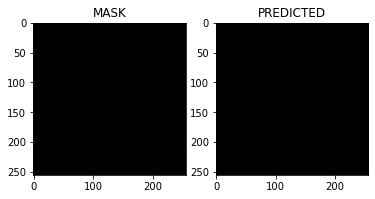

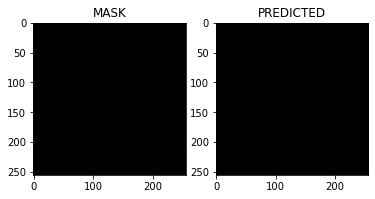

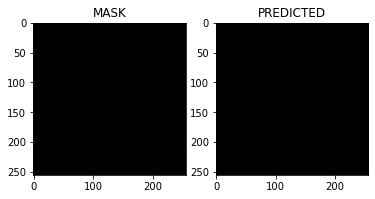

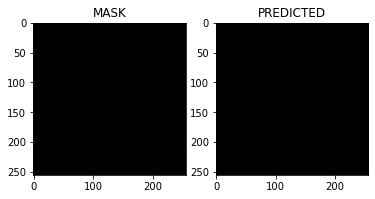

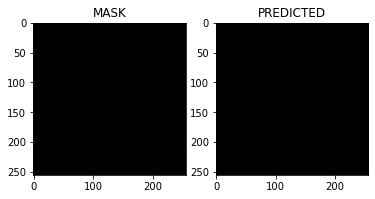

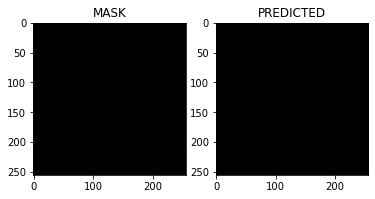

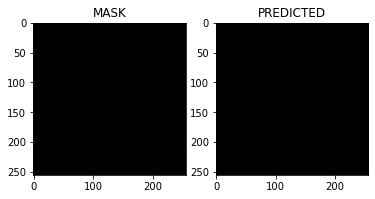

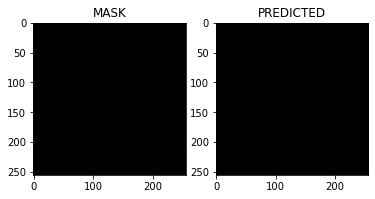

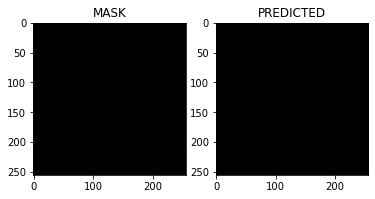

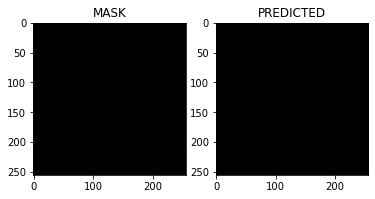

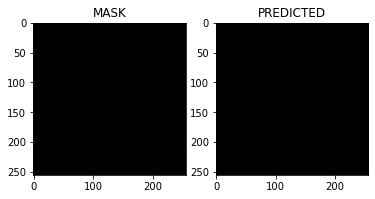

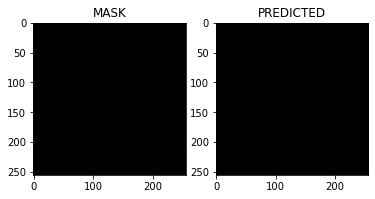

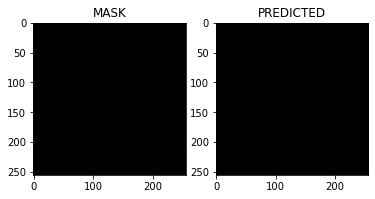

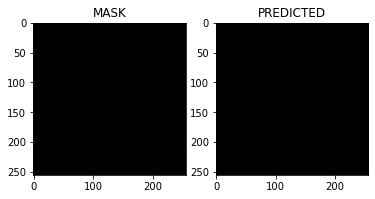

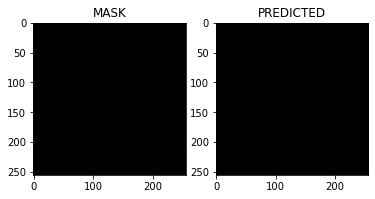

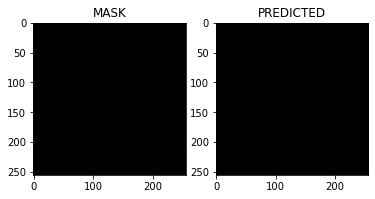

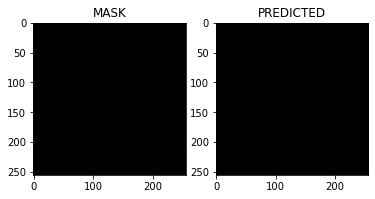

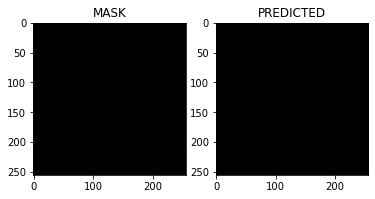

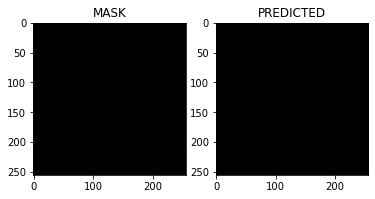

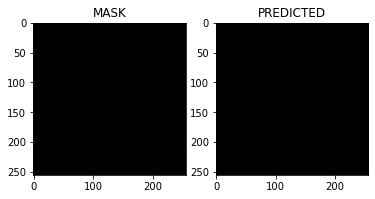

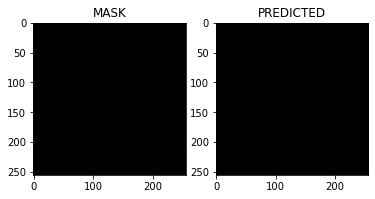

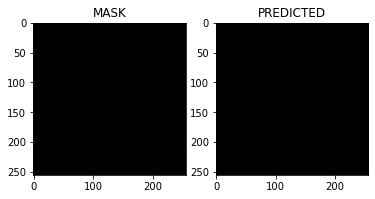

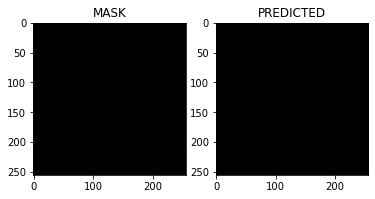

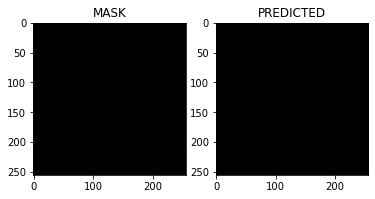

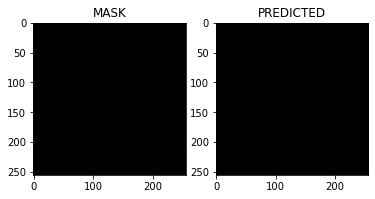

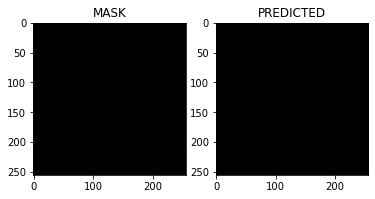

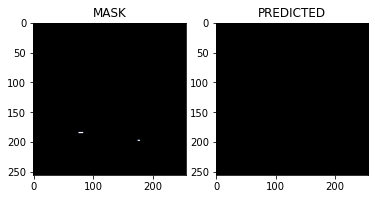

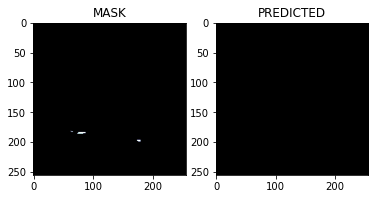

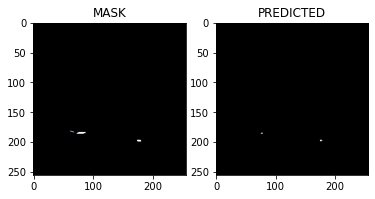

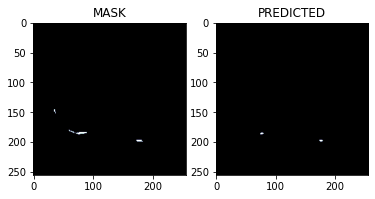

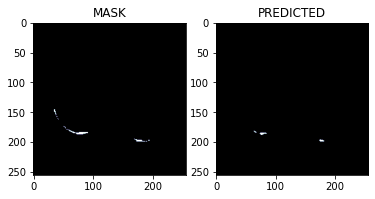

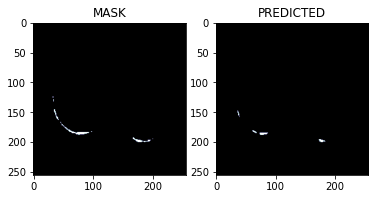

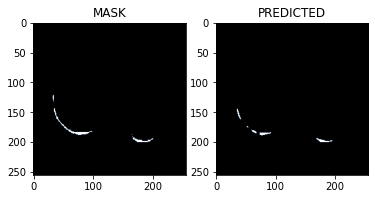

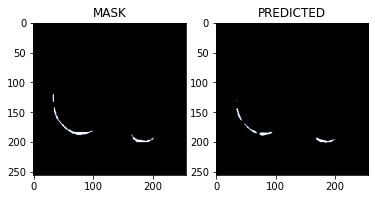

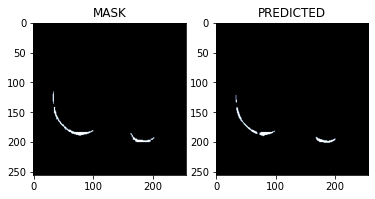

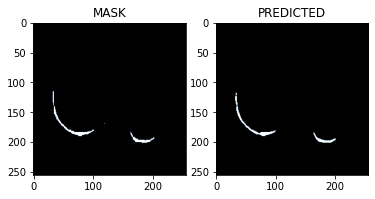

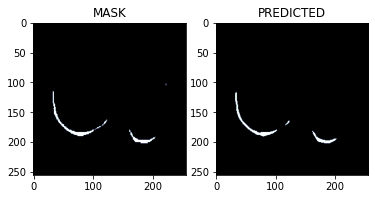

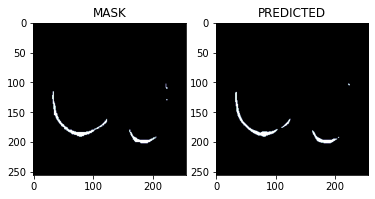

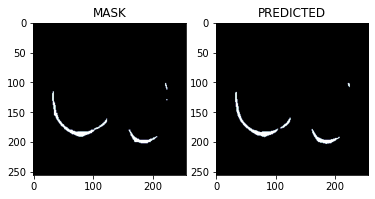

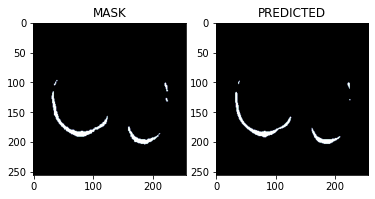

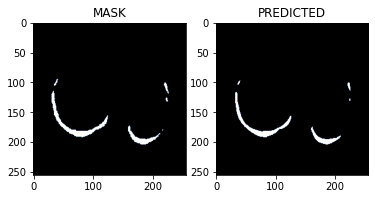

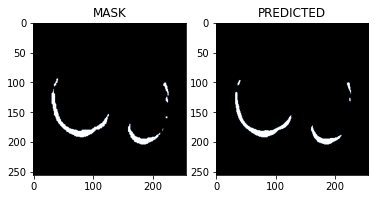

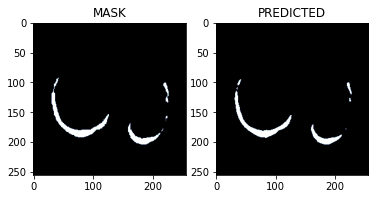

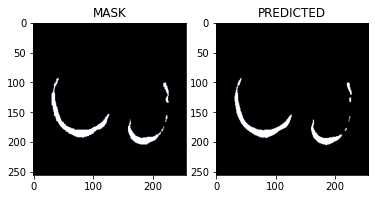

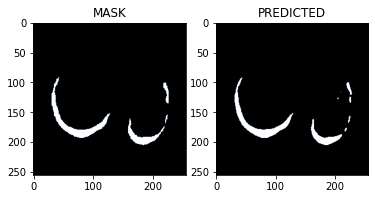

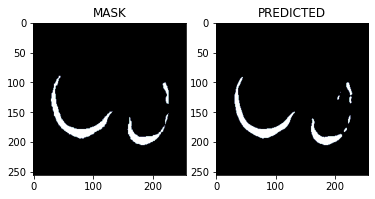

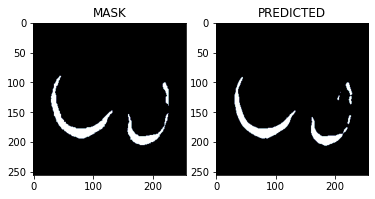

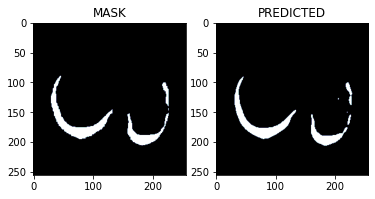

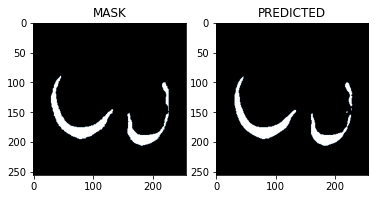

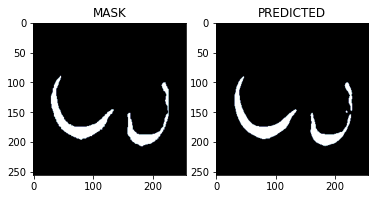

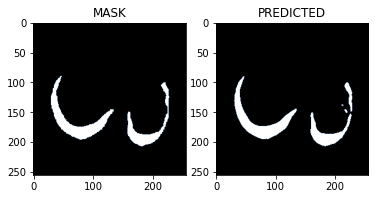

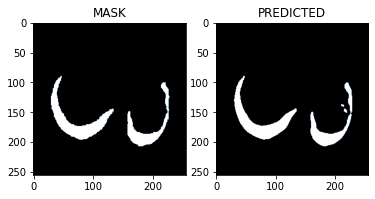

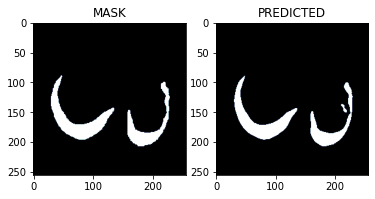

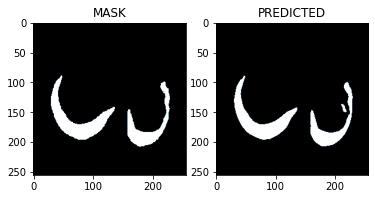

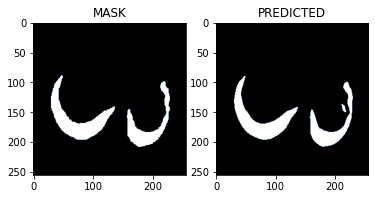

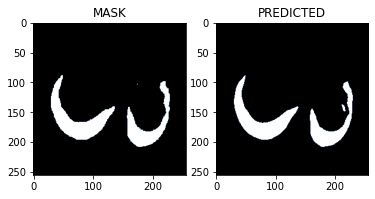

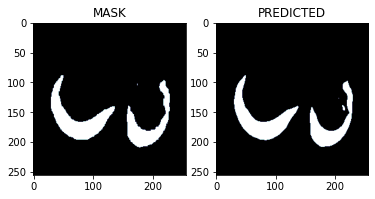

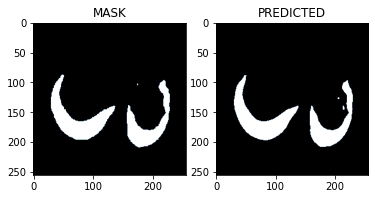

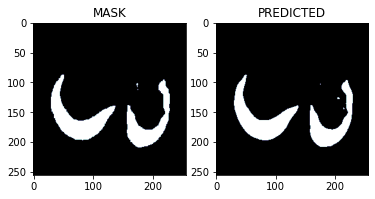

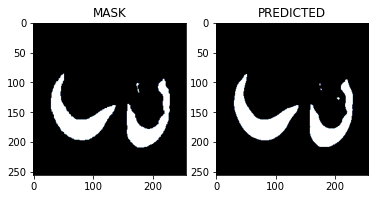

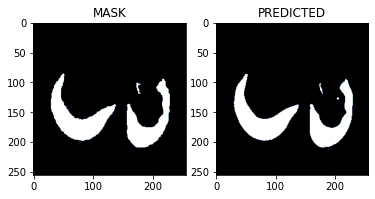

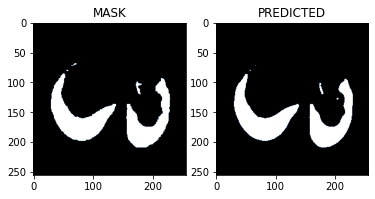

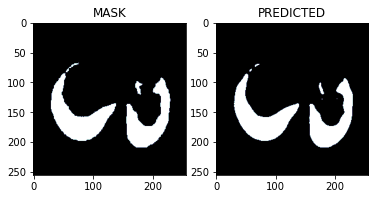

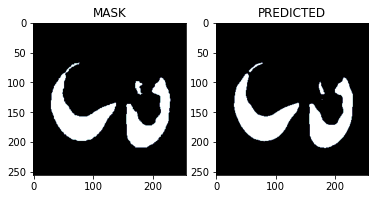

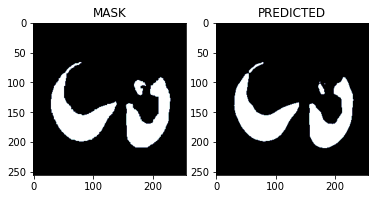

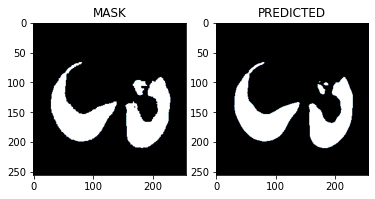

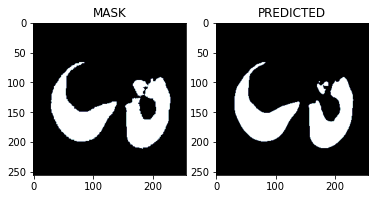

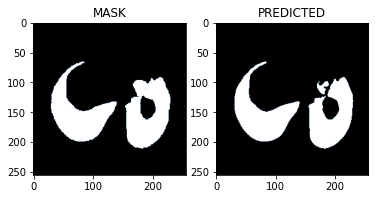

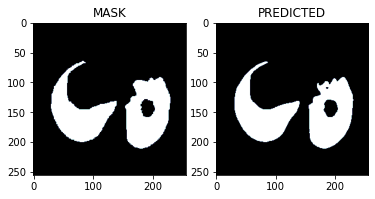

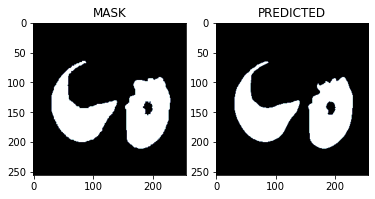

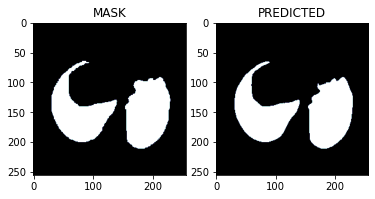

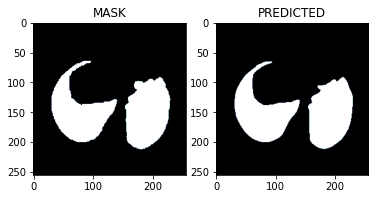

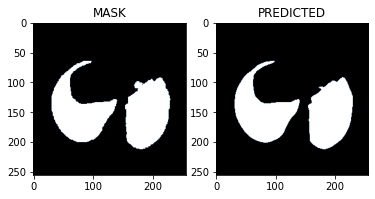

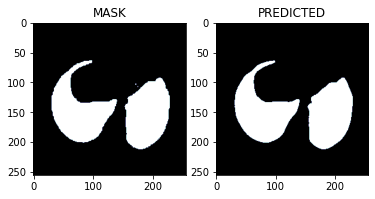

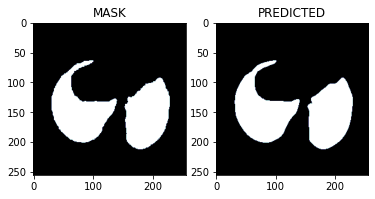

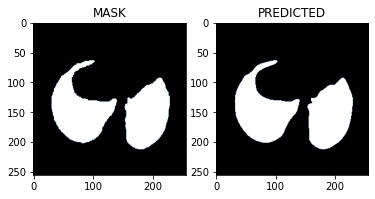

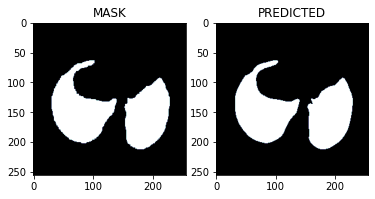

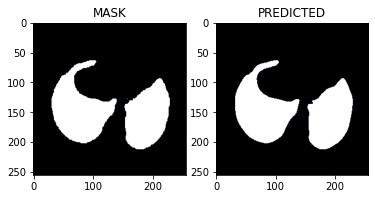

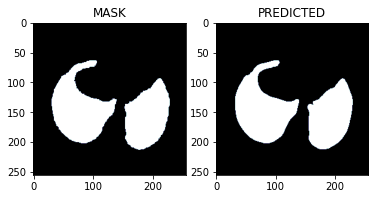

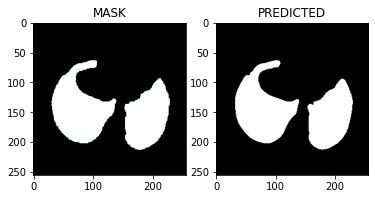

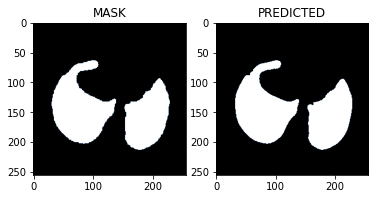

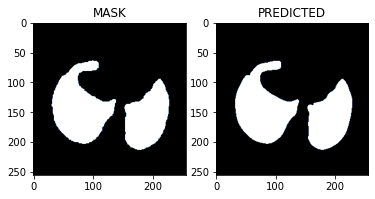

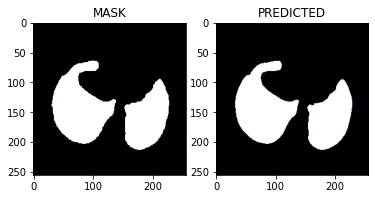

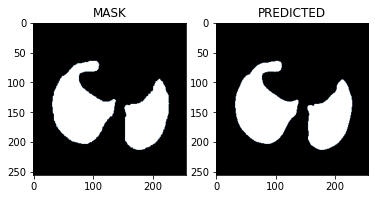

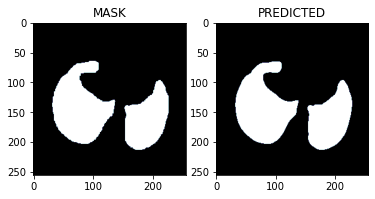

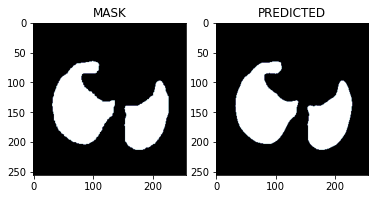

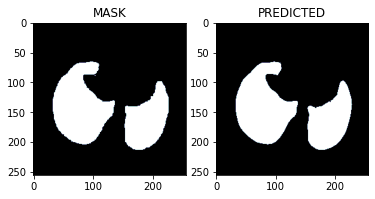

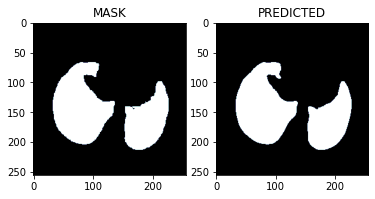

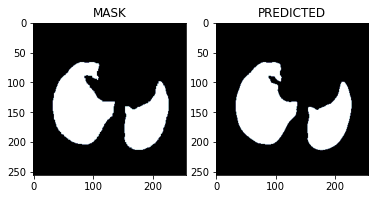

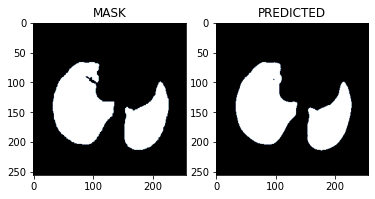

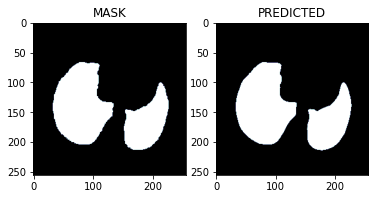

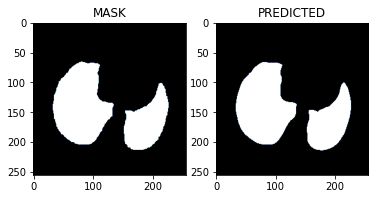

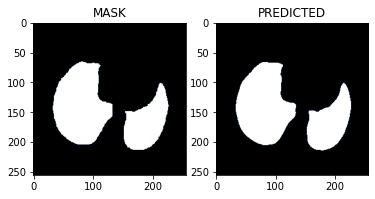

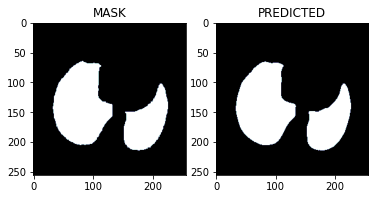

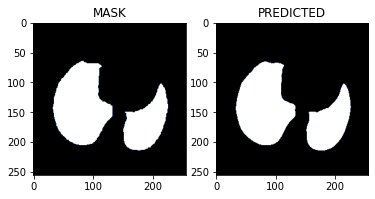

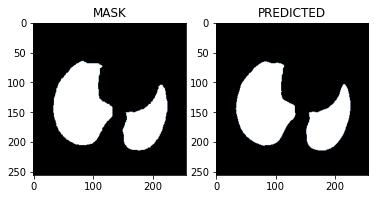

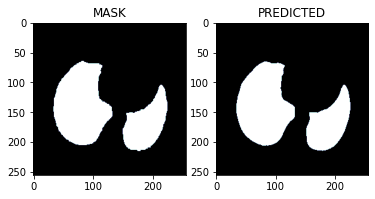

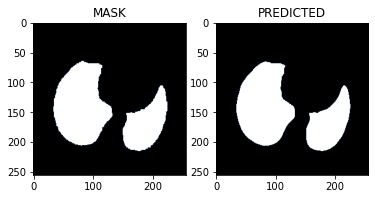

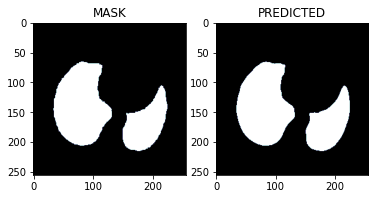

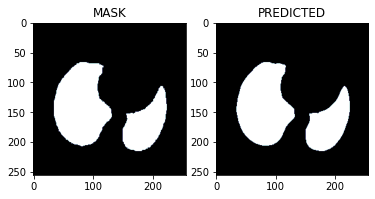

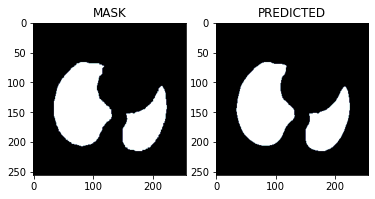

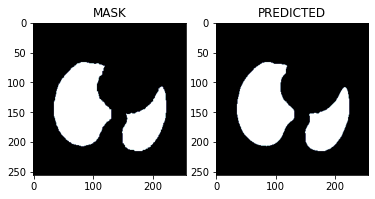

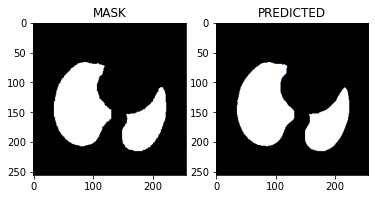

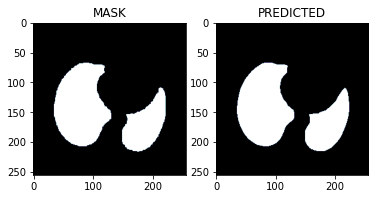

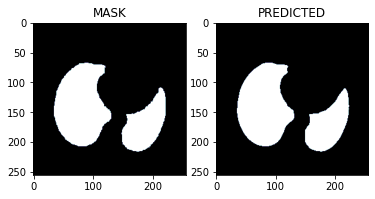

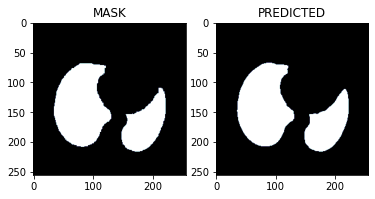

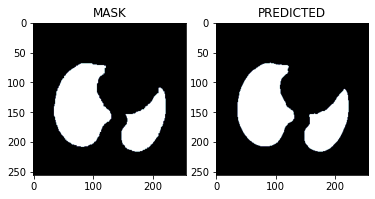

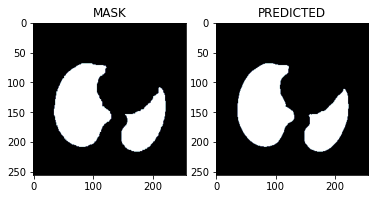

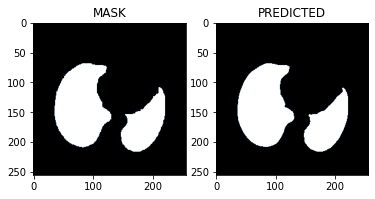

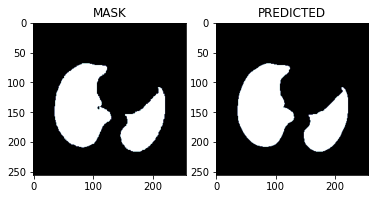

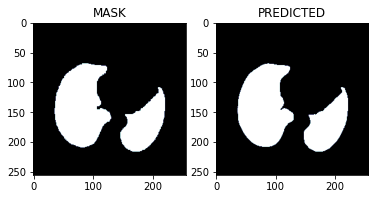

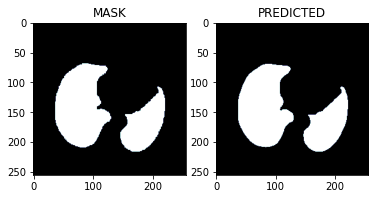

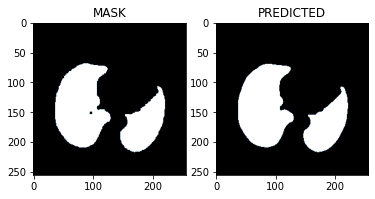

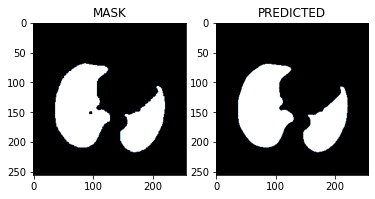

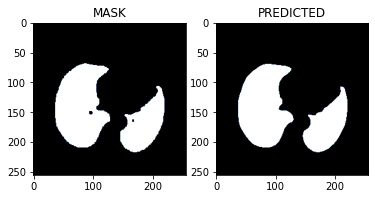

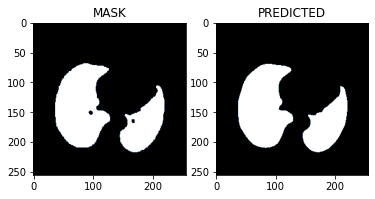

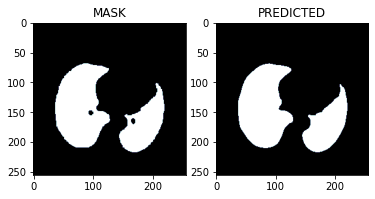

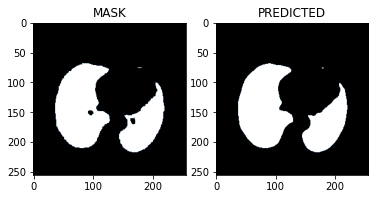

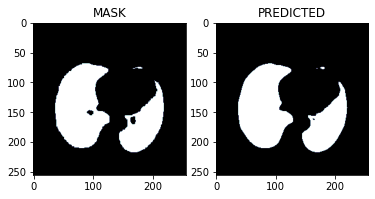

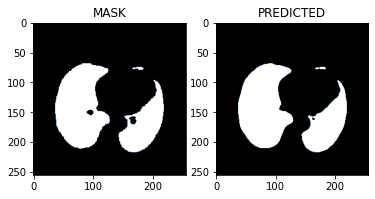

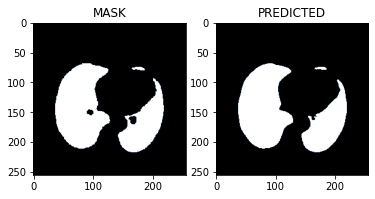

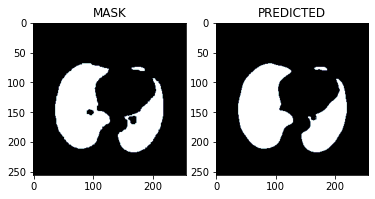

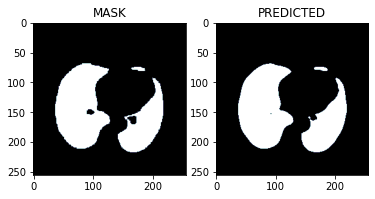

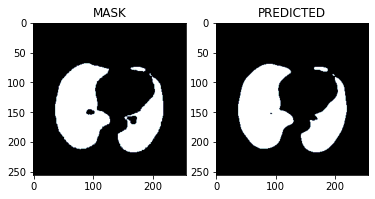

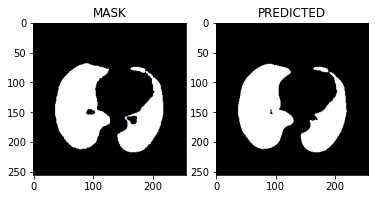

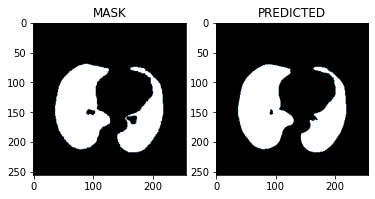

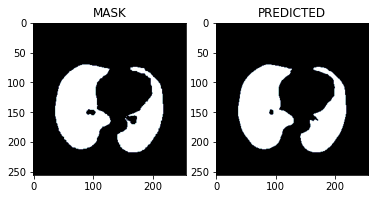

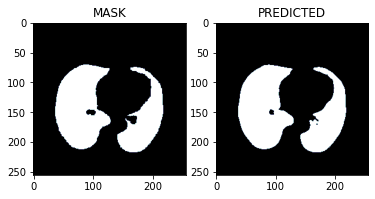

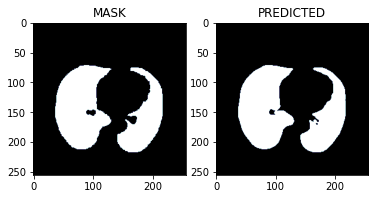

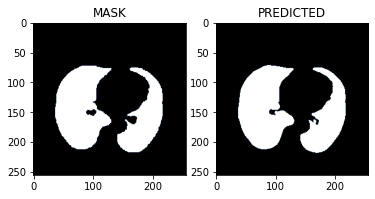

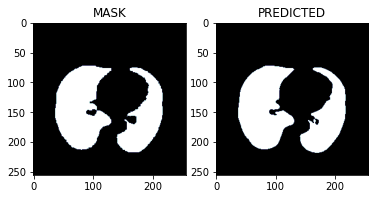

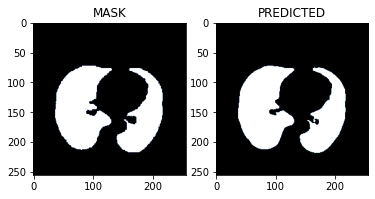

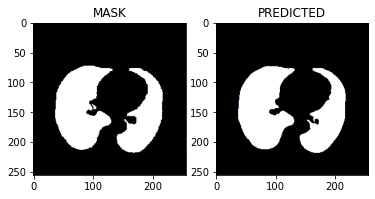

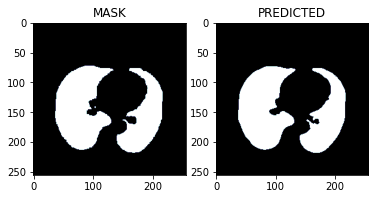

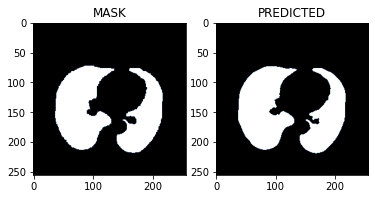

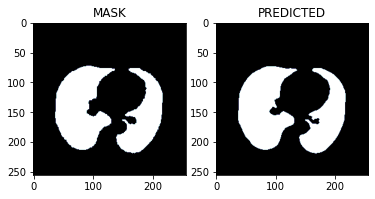

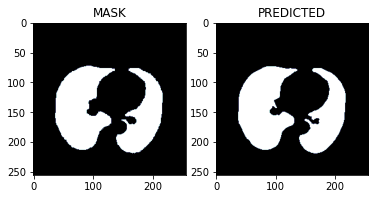

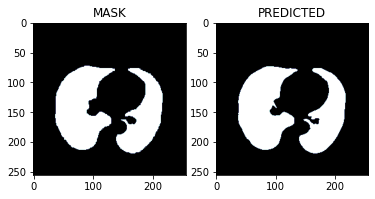

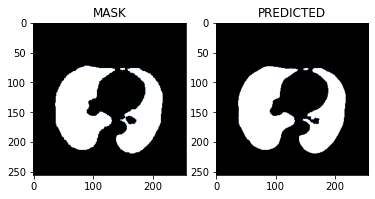

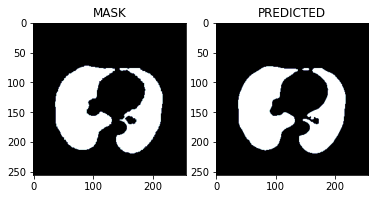

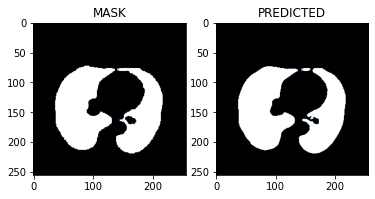

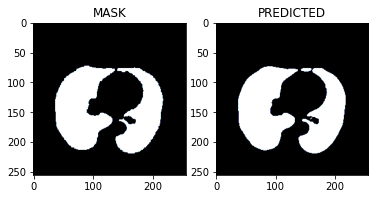

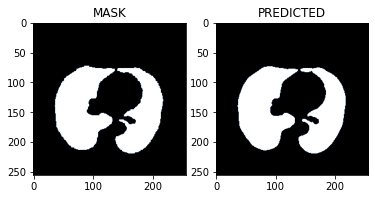

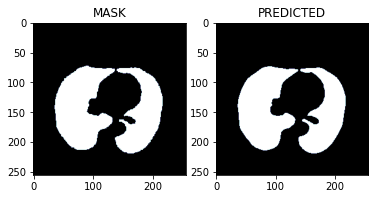

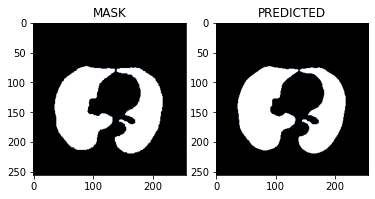

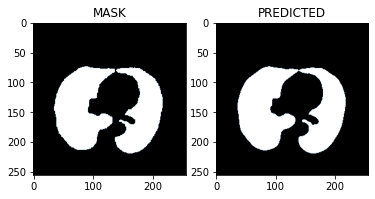

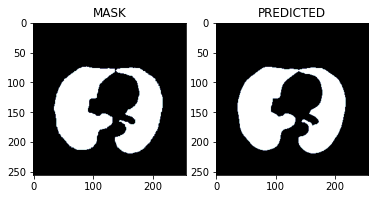

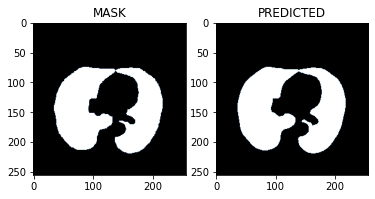

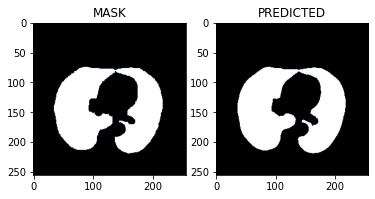

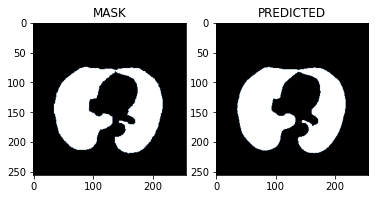

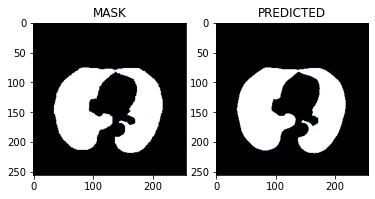

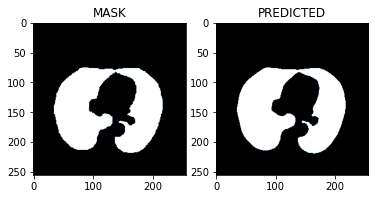

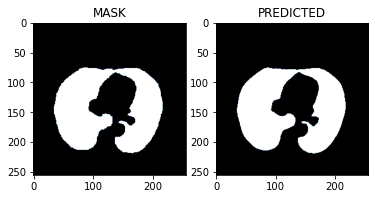

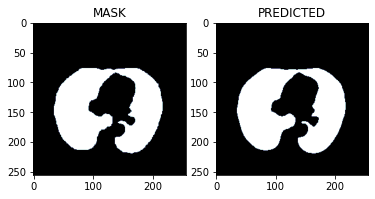

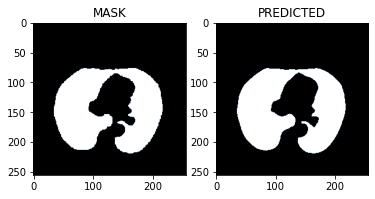

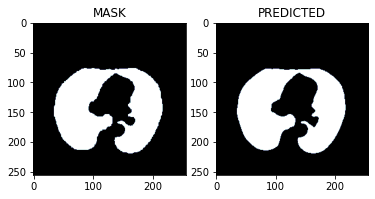

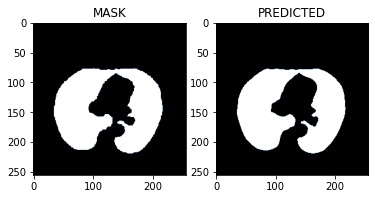

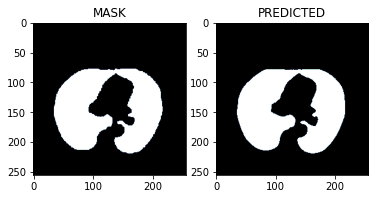

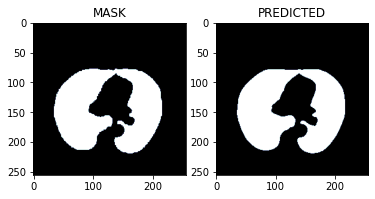

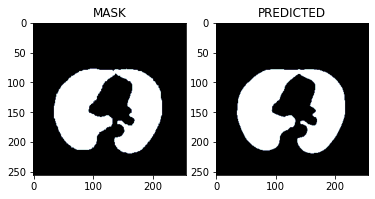

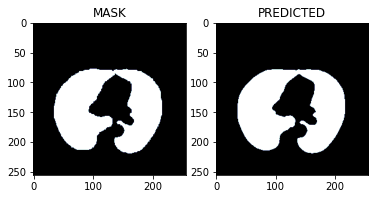

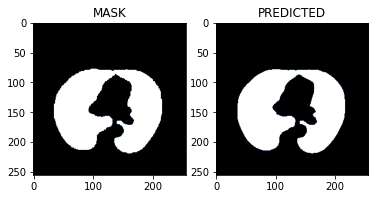

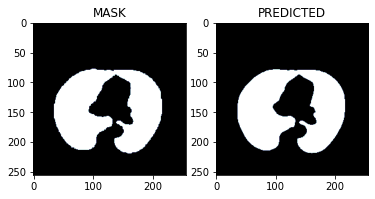

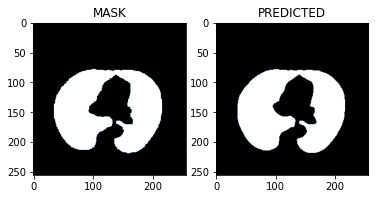

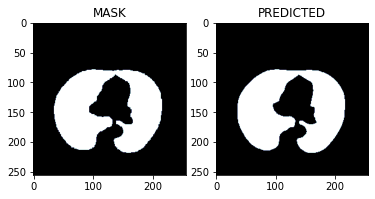

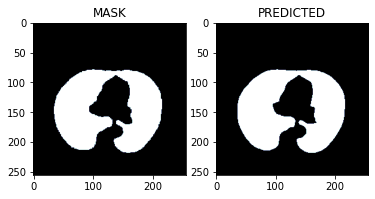

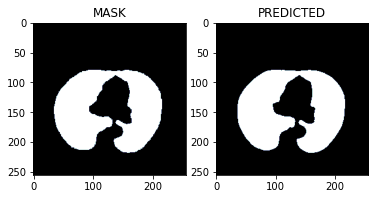

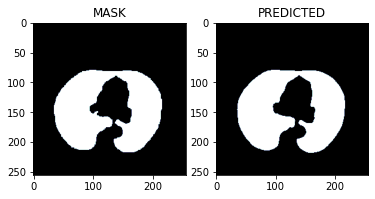

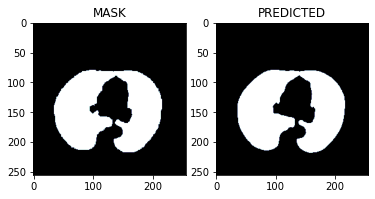

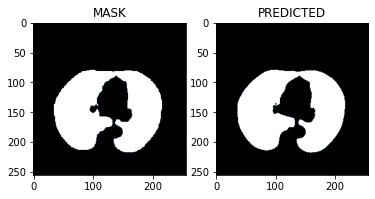

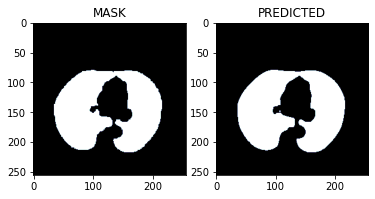

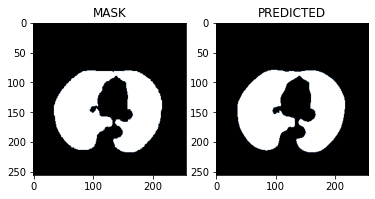

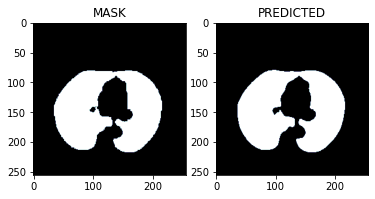

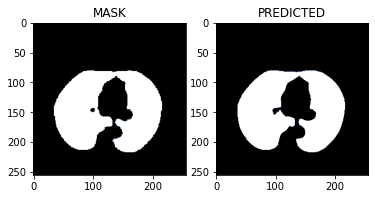

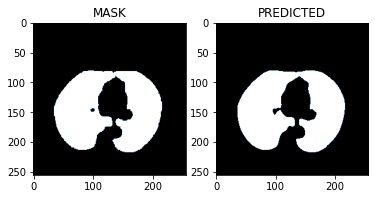

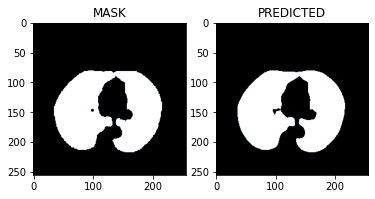

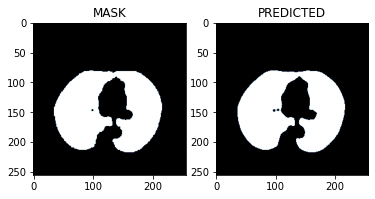

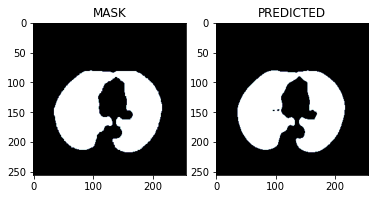

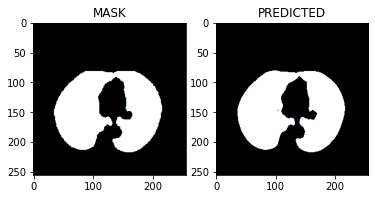

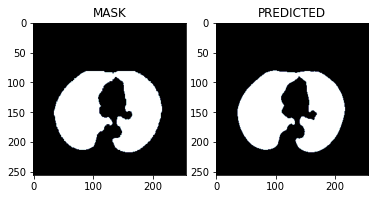

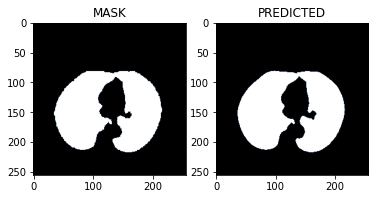

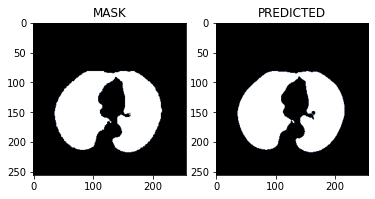

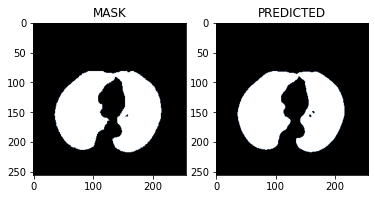

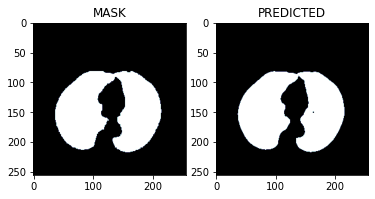

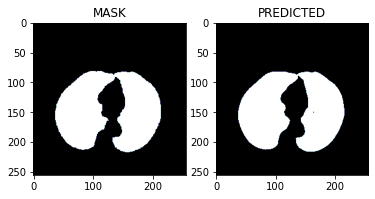

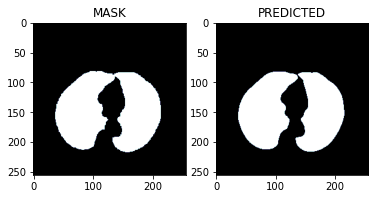

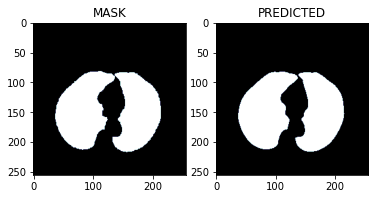

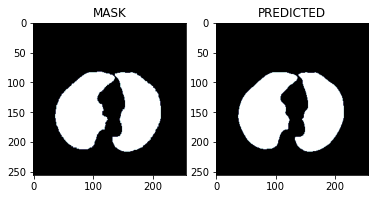

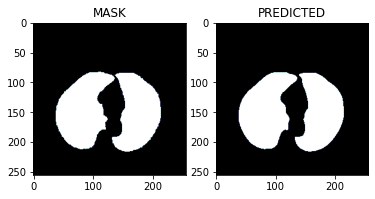

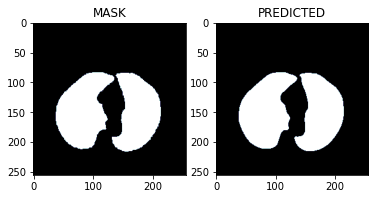

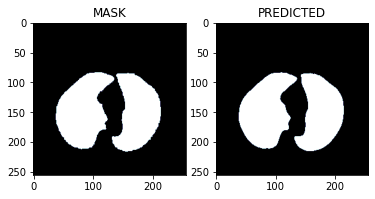

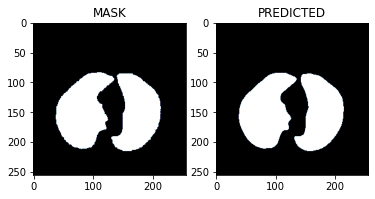

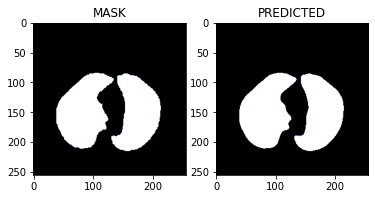

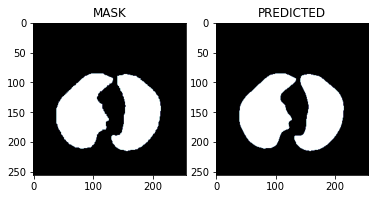

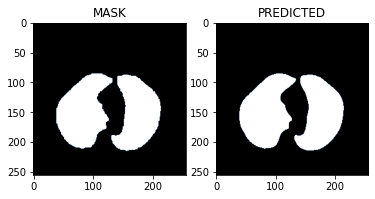

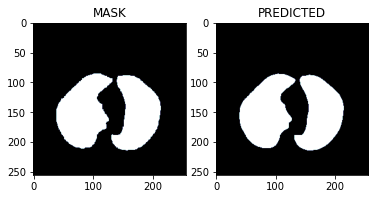

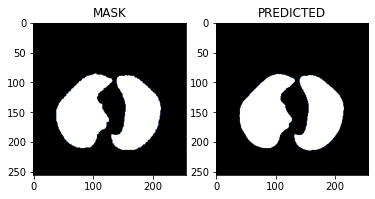

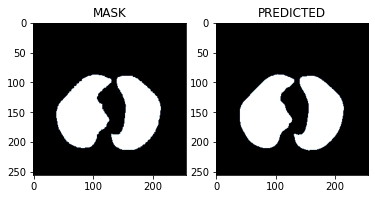

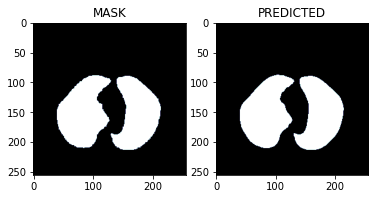

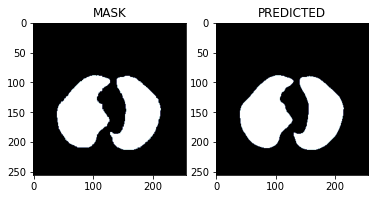

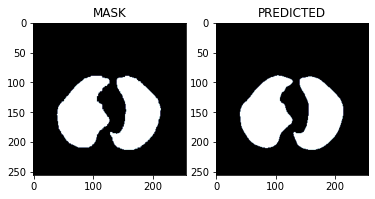

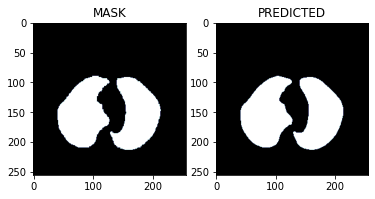

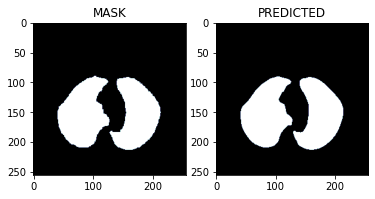

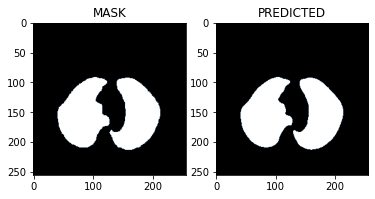

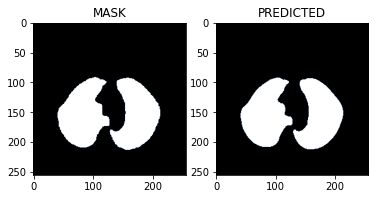

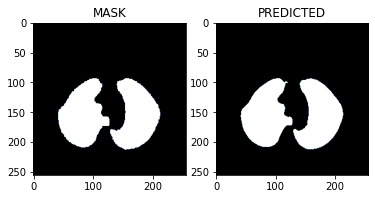

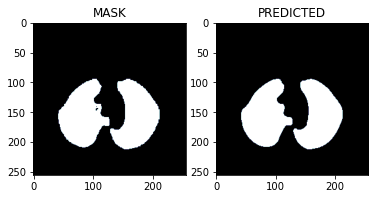

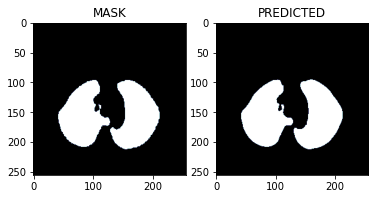

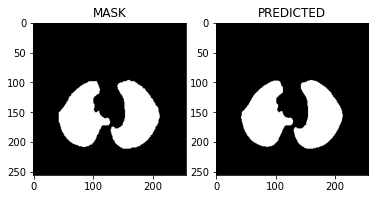

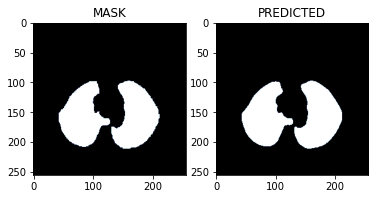

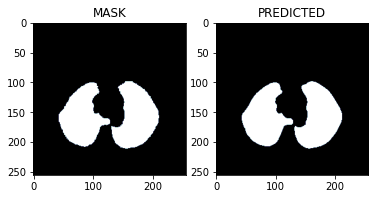

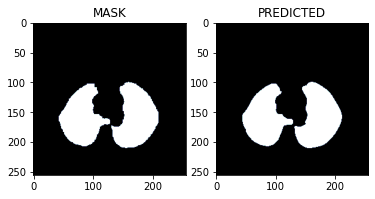

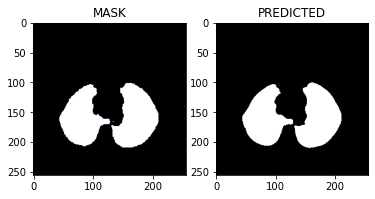

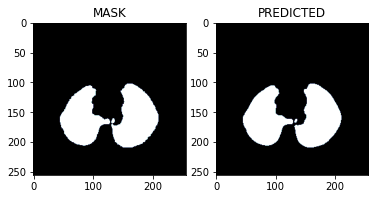

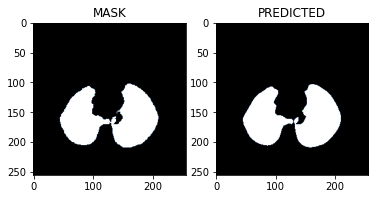

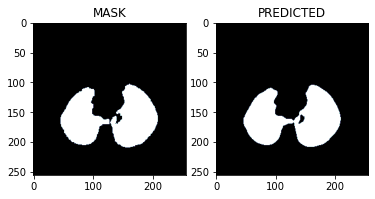

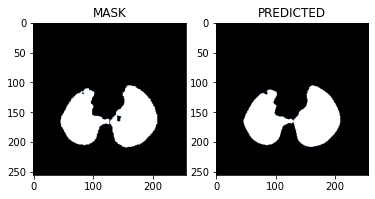

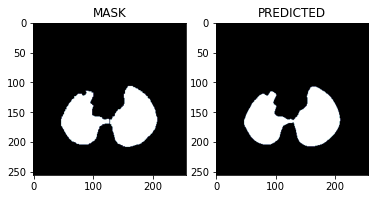

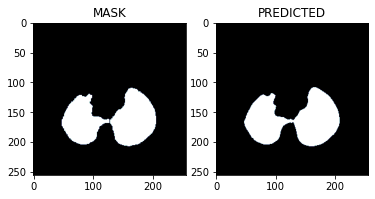

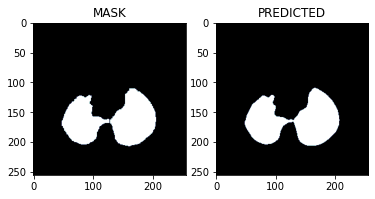

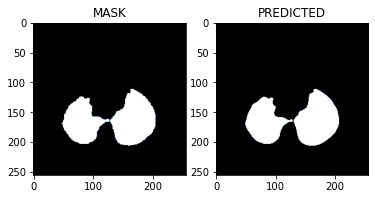

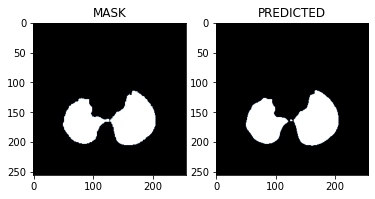

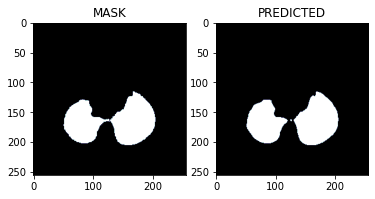

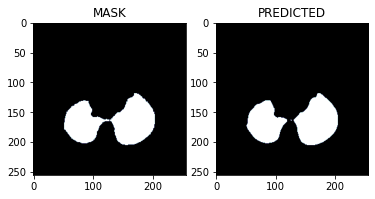

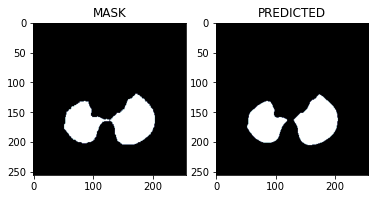

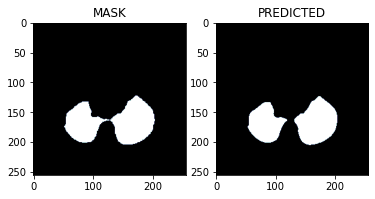

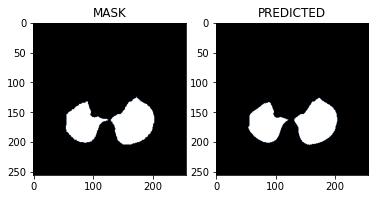

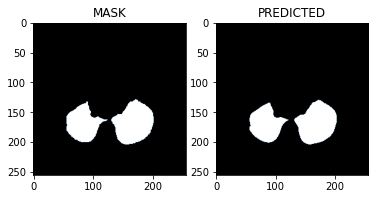

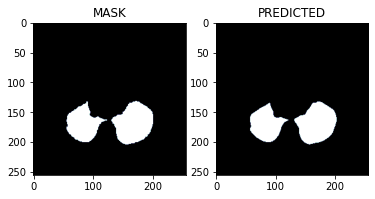

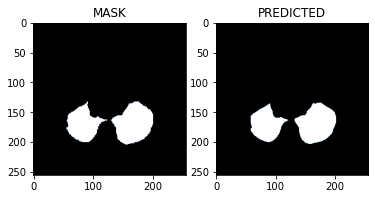

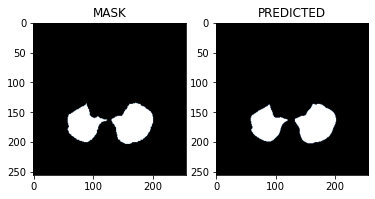

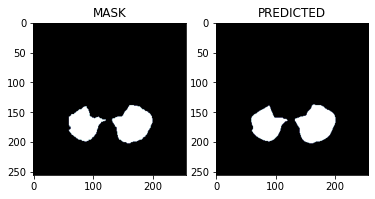

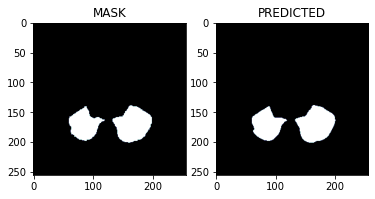

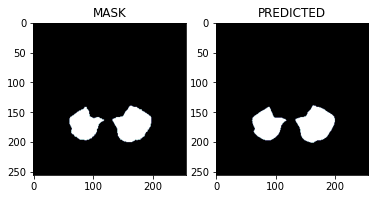

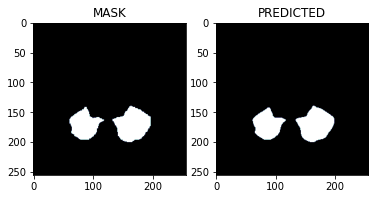

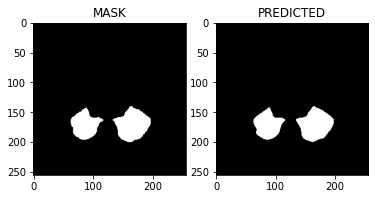

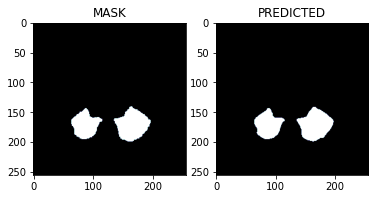

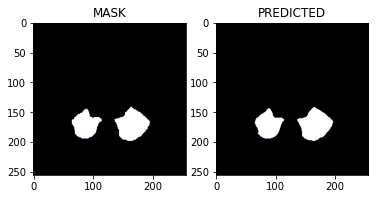

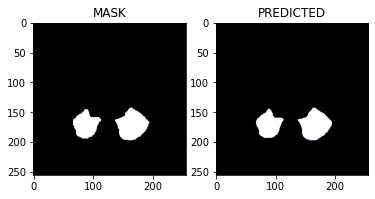

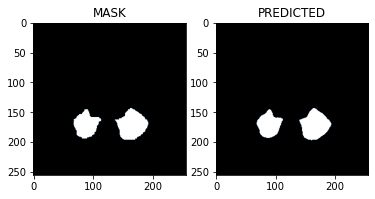

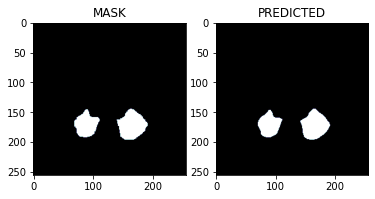

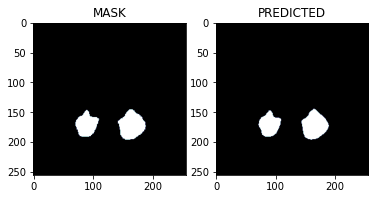

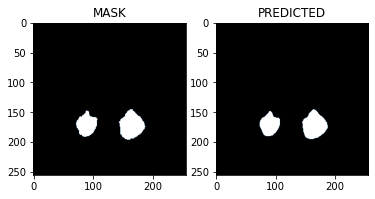

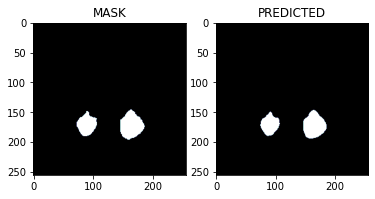

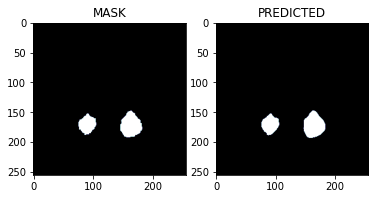

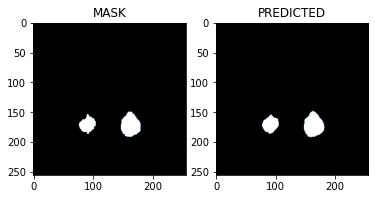

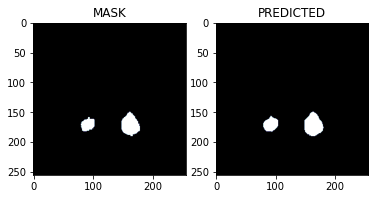

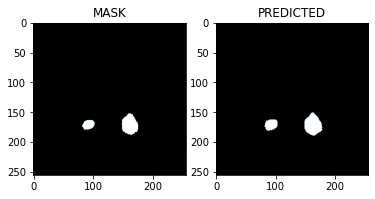

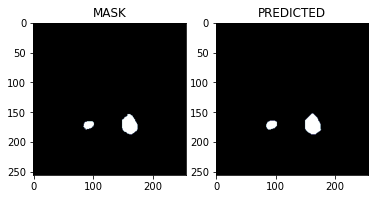

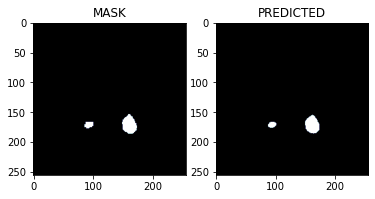

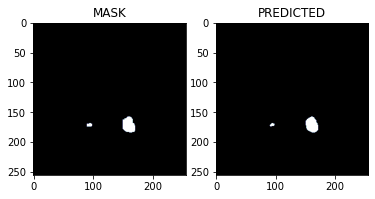

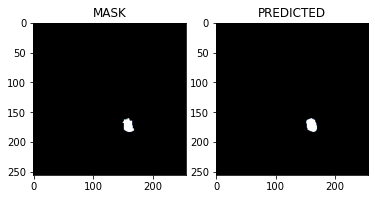

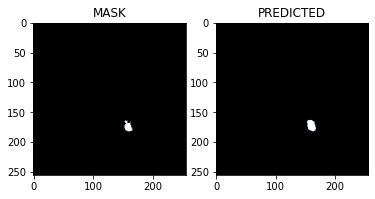

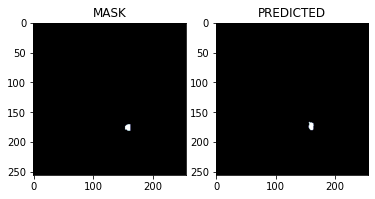

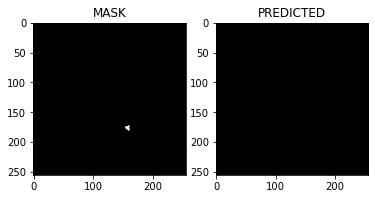

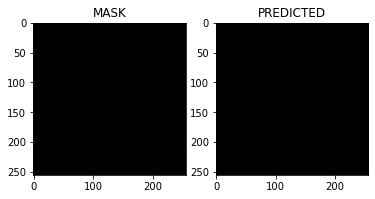

In [54]:
for i in range(256):
    plt.figure(figsize=(6, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(mask[i], cmap = plt.cm.bone)
    plt.title("MASK")
    plt.subplot(1, 2, 2)
    plt.imshow(out[i], cmap = plt.cm.bone)
    plt.title("PREDICTED")
    plt.show()

# Save Predictions 

In [ ]:
model.eval()
i = 0

with torch.no_grad():

    for val_data in val_loader:
        val_inputs, val_labels = (
            val_data["image"].to(device),
            val_data["label"].to(device),
        )
    
        val_outputs = model(val_inputs)
        val_outputs = torch.sigmoid(val_outputs)>0.5
        
        torch.save(val_outputs, 'pred_scan' + str(i) + '.pt')
        torch.save(val_labels, 'mask_scan' + str(i) + '.pt')
        i = i+1

In [ ]:
c = torch.load('Val_Output/pred_scan3.pt')

In [ ]:
c.shape

In [45]:
test_labels.shape

torch.Size([1, 1, 256, 256, 256])

In [ ]:
model.eval()

with torch.no_grad():

    for val_data in val_loader:
        val_inputs, val_labels = (
            val_data["image"].to(device),
            val_data["label"].to(device),
        )
# -----------
        # compute metric for current iteration  
#                 val_outputs = model(val_inputs)
#                 val_outputs = torch.sigmoid(val_outputs)>0.5
# ----------
        roi_size = (96, 96, 96)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
        val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
        val_labels = [post_label(i) for i in decollate_batch(val_labels)]
        dice_metric(y_pred = val_outputs, y = val_labels)


    # aggregate the final mean dice result
    metric = dice_metric.aggregate().item()